# Prepare the Notebook.

## Notebook: Mount GoogleDrive

In [4]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Notebook: Install/Import required libraries

In [5]:
!pip install -q segmentation-models-pytorch
!pip install -q split-folders
!pip install -q torchcam

In [6]:
# Standard libraries
import os
import random
import shutil
import ssl
import glob
from zipfile import ZipFile
from pprint import pprint
from PIL import Image

# Scientific and image processing libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
from scipy.ndimage import rotate

# PyTorch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from torch.autograd import Variable

# Segmentation models and losses
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.losses import DiceLoss

# Data augmentation and visualization
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics and utilities
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score

# For progress bars
from tqdm.notebook import tqdm

# External packages
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

# Data splitting tool
import splitfolders

In [7]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

## Function: Zip Downloader

In [8]:
def download_data(set='removed'):
    if set == 'full':
        print('Loading Full Data: ')
        zip_file_path = "/content/drive/MyDrive/Assignment_DLIVP/Data/removed.zip"
        extract_to_path = "/content/data/"
        os.makedirs(extract_to_path, exist_ok=True)

        with ZipFile(zip_file_path, 'r') as zip_ref:
            file_names = zip_ref.namelist()
            with tqdm(total=len(file_names), desc="Extracting") as pbar:
                for file in file_names:
                    zip_ref.extract(file, extract_to_path)
                    pbar.update(1)

    # if set == 'removed' or 'full'
    if set=='removed':
        print('Loading Cleaned Data: ')
    zip_file_path = "/content/drive/My Drive/Assignment_DLIVP/Data/output.zip"
    extract_to_path = "/content/data/"
    os.makedirs(extract_to_path, exist_ok=True)

    with ZipFile(zip_file_path, 'r') as zip_ref:
        file_names = zip_ref.namelist()
        with tqdm(total=len(file_names), desc="Extracting") as pbar:
            for file in file_names:
                zip_ref.extract(file, extract_to_path)
                pbar.update(1)

    print("Extraction complete!")

    def check_files(path):
        images_folder = f'/content/data/{path}/images'
        masks_folder = f'/content/data/{path}/labels'

        images_count = len(glob.glob(os.path.join(images_folder, "*.png")))
        masks_count = len(glob.glob(os.path.join(masks_folder, "*.png")))

        print(f"Number of PNG files in {images_folder}: {images_count}")
        print(f"Number of PNG files in {masks_folder}: {masks_count}")

    # Example usage:
    check_files('output')
    if set=='full':
      check_files('removed')

## Functions: to Organise the Folders

In [9]:
# Function organise and move files
def organize_files(input_dir, output_dir, image_or_label):
    files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    for filename in tqdm(files, desc=f'Organizing {image_or_label}'):
        time_phase = 'pre' if '_pre_' in filename else 'post'

        dir_path = os.path.join(output_base_dir, time_phase, image_or_label)
        os.makedirs(dir_path, exist_ok=True)

        src_file = os.path.join(input_dir, filename)
        dst_file = os.path.join(dir_path, filename)
        task(src_file, dst_file)


# Function to create new directories and move files
def reorganize_files(original_dir, new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    for filename in os.listdir(original_dir):
        shutil.move(os.path.join(original_dir, filename), os.path.join(new_dir, filename))

## Function: Visualize Images and Masks

In [10]:
def visualize_sample(dataset):
    image, mask = dataset[50]
    image = image.numpy().transpose(1, 2, 0)

    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze())
    plt.show()

## Functions: For training

### Augmentations

In [11]:
def setaugmentation(setaug='full'):
    val_transform = A.Compose([     # Simple transformations
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    test_transform = val_transform  # Same as validation

    if setaug=='full':

        train_transform = A.Compose([   # Hard Augmentations for training set
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.2),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
            A.RandomGridShuffle(grid=(3, 3), p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        train_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    return train_transform, val_transform, test_transform

### Loss and Metric

In [12]:
def jaccard_loss(true, logits, eps=1e-7):
    """Calculate the Jaccard loss, a.k.a IOU loss"""
    probas = torch.sigmoid(logits)
    true_1d = true.view(-1)
    probas_1d = probas.view(-1)

    intersection = (true_1d * probas_1d).sum()
    total = true_1d.sum() + probas_1d.sum()
    union = total - intersection

    jaccard = (intersection + eps) / (union + eps)
    return 1 - jaccard

# Dice Coefficient function for metric calculation
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

In [13]:
# class BinaryDiceLoss(nn.Module):
#     def __init__(self):
#         super(BinaryDiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
#         # Flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

#         return 1 - dice
# def dice_coefficient(pred, target, smooth=1e-6):
#     """
#     Calculate the Dice Coefficient.
#     :param pred: Predicted tensor
#     :param target: Ground truth tensor
#     :param smooth: A small constant to avoid division by zero
#     :return: Dice Coefficient
#     """
#     pred_flat = pred.contiguous().view(-1)
#     target_flat = target.contiguous().view(-1)

#     intersection = (pred_flat * target_flat).sum()
#     return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
# def iou_score(pred, target, smooth=1e-6):
#     """
#     Calculate the Intersection over Union (IoU) score.
#     :param pred: Predicted tensor
#     :param target: Ground truth tensor
#     :param smooth: A small constant to avoid division by zero
#     :return: IoU score
#     """
#     pred_flat = pred.contiguous().view(-1)
#     target_flat = target.contiguous().view(-1)

#     intersection = (pred_flat * target_flat).sum()
#     union = pred_flat.sum() + target_flat.sum() - intersection
#     return (intersection + smooth) / (union + smooth)

# bce_loss = nn.BCEWithLogitsLoss()
# dice_loss = BinaryDiceLoss()
# def dice_loss(pred, target, smooth = 1.):
#     pred = torch.sigmoid(pred)
#     pred_flat = pred.view(-1)
#     target_flat = target.view(-1)
#     intersection = (pred_flat * target_flat).sum()
#     return 1 - ((2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth))
# def iou_score(preds, targets, smooth=1e-6):
#     """
#     Computes the IoU score (Jaccard Index) for predicted and target masks.

#     Args:
#     - preds (Tensor): Predicted segmentation masks.
#     - targets (Tensor): Ground truth segmentation masks.
#     - smooth (float): Small constant to avoid division by zero.

#     Returns:
#     - float: IoU score.
#     """
#     # Convert predictions to binary (0 or 1) using a threshold (e.g., 0.5)
#     preds = torch.sigmoid(preds)
#     preds = (preds > 0.5).float()

#     # Flatten the tensors to compare them pixel-wise
#     preds_flat = preds.view(-1)
#     targets_flat = targets.view(-1)

#     # Calculate intersection and union
#     intersection = (preds_flat * targets_flat).sum()
#     union = preds_flat.sum() + targets_flat.sum() - intersection

#     # Compute IoU
#     iou = (intersection + smooth) / (union + smooth)

#     return iou.item()  # Convert to Python scalar


### Model Creation

In [14]:
def create_model(architecture='unet',backbone='resnet50', pretrained='imagenet'):
    if architecture=='unet':
      return smp.Unet(encoder_name=backbone, encoder_weights=pretrained, in_channels=3, classes=1)
    if architecture=='unet++':
      return smp.UnetPlusPlus(encoder_name=backbone, encoder_weights=pretrained, in_channels=3, classes=1)

### Train_Validation

In [15]:
def train_one_epoch(model, dataloader, optimizer, device, accumulation_steps):
    model.train()
    running_loss, running_metric = 0.0, 0.0

    for batch_index, (images, masks) in enumerate(tqdm(dataloader, desc='Training')):
        images, masks = images.to(device), masks.to(device).unsqueeze(1)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = jaccard_loss(masks, outputs) / accumulation_steps

        scaler.scale(loss).backward()

        if (batch_index + 1) % accumulation_steps == 0 or batch_index + 1 == len(dataloader):
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * accumulation_steps
        running_metric += dice_coefficient(outputs, masks)

    avg_loss = running_loss / len(dataloader)
    avg_metric = running_metric / len(dataloader)

    return avg_loss, avg_metric

def validate_one_epoch(model, dataloader, device):
    model.eval()
    val_loss, val_metric = 0.0, 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validation'):
            images, masks = images.to(device), masks.to(device).unsqueeze(1)
            outputs = model(images)
            loss = jaccard_loss(masks, outputs)
            val_loss += loss.item()
            val_metric += dice_coefficient(outputs, masks)

    avg_loss = val_loss / len(dataloader)
    avg_metric = val_metric / len(dataloader)

    return avg_loss, avg_metric

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def train_and_validate_model(model,
                             train_dataloader,
                             valid_dataloader,
                             optimizer,
                             scheduler,
                             device,
                             num_epochs,
                             accumulation_steps,
                             patience,
                             folder,
                             model_name,
                             save_interval):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('Patience for early stopping:', patience)
        print('Epochs with no improvement in the validation loss:', epochs_no_improve)

        avg_train_loss, avg_train_metric = train_one_epoch(model, train_dataloader, optimizer, device, accumulation_steps)
        scheduler.step(avg_train_loss)
        avg_val_loss, avg_val_metric = validate_one_epoch(model, valid_dataloader, device)

        # Logging training and validation metrics
        # writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        # writer.add_scalar('Metric/Train', avg_train_metric, epoch)
        # writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        # writer.add_scalar('Metric/Validation', avg_val_metric, epoch)

        print(f"Training Loss: {avg_train_loss:.4f}, Training Metric: {avg_train_metric:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Metric: {avg_val_metric:.4f}")

        # # Save model every 'save_interval' epochs
        # if (epoch + 1) % save_interval == 0:
        #     save_path = f'/content/drive/MyDrive/{folder}/{model_name}_epoch_{epoch+1}.pth'
        #     save_model(model, save_path)

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_model(model, f'/content/drive/MyDrive/{folder}/best_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                early_stop = True
                break

    if not early_stop:
        print("Completed all epochs without early stopping.")

    # Save the final model
    save_model(model, f'/content/drive/MyDrive/{folder}/final_model.pth')
    # writer.close()

In [16]:
# def train_the_model(archi='unet',
#                     backbone='resnext50_32x4d', # resnext50_32x4d or resnet50
#                     pretrained='imagenet', # imagenet or None
#                     freezer=True, # True or False
#                     n_cpu=8, # 2 or 8
#                     batch_size=32,
#                     num_epochs=50,
#                     patience=10,
#                     early_stop=False,
#                     save_interval=2,  # Save weights every 2 epochs
#                     accumulation_steps=4  # Gradient accumulation steps
#                     ):
#   # Setup
#   model_name=archi+'_'+backbone
#   if freezer:
#     folder = f'{archi}_{backbone}_{pretrained}_b'
#   else:
#     folder = f'{archi}_{backbone}_{pretrained}'
#   path =f'/content/drive/MyDrive/{folder}'
#   os.makedirs(path, exist_ok=True)

#   # DataLoaders
#   train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
#   valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

#   # Training setup
#   device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#   if pretrained == 'imagenet':
#     model = create_model(architecture=archi, backbone=backbone).to(device)
#   else:
#     model = create_model(architecture=archi, backbone=backbone, pretrained=None).to(device)

#   optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
#   scaler = GradScaler()

#   best_val_loss = float('inf')
#   epochs_no_improve = 0

#   if freezer:
#     for param in model.encoder.parameters():
#         param.requires_grad = False

#   # RUN
#   train_and_validate_model(model,
#                           train_dataloader,
#                           valid_dataloader,
#                           optimizer,
#                           scheduler,
#                           device,
#                           num_epochs,
#                           accumulation_steps,
#                           patience,
#                           folder,
#                           model_name,
#                           save_interval)

## Functions: For evaluation and Explainability

In [17]:
def plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='model'):
    epochs = list(range(1, epochs+1))

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    loss_plot_filename = f'{model_name}_loss_curve.png'
    plt.savefig(loss_plot_filename)  # Save the figure
    plt.show()

    # Plot training and validation metric (Dice Score)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_metric, label='Training Metric (Dice Score)')
    plt.plot(epochs, validation_metric, label='Validation Metric (Dice Score)')
    plt.title('Training and Validation Metric (Dice Score) Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)
    metric_plot_filename = f'{model_name}_metric_curve.png'
    plt.savefig(metric_plot_filename)  # Save the figure
    plt.show()

    return loss_plot_filename, metric_plot_filename

def load_model_weights(model, weight_path, device='cuda'):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model


def compute_metrics(model, test_loader, device='cuda'):
    total_metrics = {"accuracy": [], "iou": []}
    threshold = 0.5  # Threshold for binary mask conversion

    with torch.no_grad():
        for inputs, true_masks in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, true_masks = inputs.to(device), true_masks.to(device)
            predicted_masks = model(inputs)

            predicted_masks = (predicted_masks > threshold).float()

            true_masks = true_masks.squeeze(1)

            true_masks_flat = true_masks.view(-1).cpu().numpy()
            predicted_masks_flat = predicted_masks.view(-1).cpu().numpy()

            acc = accuracy_score(true_masks_flat, predicted_masks_flat)
            iou = jaccard_score(true_masks_flat, predicted_masks_flat, average='macro')

            total_metrics["accuracy"].append(acc)
            total_metrics["iou"].append(iou)

    for metric in total_metrics:
        total_metrics[metric] = np.mean(total_metrics[metric])

    return total_metrics

def normalize_image(img):
    """Normalize image data to [0, 1] range."""
    img = img - img.min()
    img = img / img.max()
    return img

def generate_saliency_map(model, image_tensor):
    model.eval()

    image_tensor.requires_grad_()

    output = model(image_tensor)

    _, predicted_class = output.max(1)

    model.zero_grad()

    target = torch.zeros_like(output)
    target[0][predicted_class] = 1

    output.backward(gradient=target)

    saliency, _ = torch.max(image_tensor.grad.data.abs(), dim=1)

    return saliency

def generate_saliency_map_segmentation(model, image_tensor, target_class):
    model.eval()
    image_tensor.requires_grad = True


    prediction = model(image_tensor)

    target = prediction[:, target_class, :, :]
    target = target.mean()
    target.backward()

    gradients = image_tensor.grad.data

    saliency_map = gradients.abs().squeeze().sum(dim=0)
    saliency_map = saliency_map - saliency_map.min()
    saliency_map = saliency_map / saliency_map.max()

    return saliency_map


def visualize_predictions_and_explain(model, test_loader, num_images=30, save_path='', device='cuda', seed=42, title=''):
    random.seed(seed)
    random_indices = random.sample(range(len(test_loader.dataset)), num_images)

    if save_path:
        os.makedirs(save_path, exist_ok=True)

    for i, idx in enumerate(random_indices):
        image, true_mask = test_loader.dataset[idx]

        image_tensor = image.unsqueeze(0).to(device)

        saliency_map = generate_saliency_map(model, image_tensor).cpu().numpy()[0]
        saliency_map = normalize_image(saliency_map)

        fig = plt.figure(figsize=(20, 6))

        # Display original image
        ax1 = fig.add_subplot(1, 6, 1)
        ax1.imshow(normalize_image(image.permute(1, 2, 0)))  # Normalize and display the image
        ax1.set_title("Original Image")
        ax1.axis('off')

        # Display true mask
        ax2 = fig.add_subplot(1, 6, 2)
        ax2.imshow(true_mask, cmap='gray')  # Display true mask
        ax2.set_title("True Mask")
        ax2.axis('off')

        # Display predicted mask as is (probability map)
        with torch.no_grad():
            predicted_probs = model(image_tensor)
            predicted_probs = predicted_probs.squeeze().cpu()

        ax3 = fig.add_subplot(1, 6, 3)
        ax3.imshow(predicted_probs.numpy(), cmap='jet')  # Display probability map
        ax3.set_title("Predicted Probabilities")
        ax3.axis('off')

        # Display predicted mask as binary
        predicted_mask_binary = predicted_probs > 0.5  # Apply threshold to get binary mask

        ax4 = fig.add_subplot(1, 6, 4)
        ax4.imshow(predicted_mask_binary.numpy(), cmap='gray')  # Display binary predicted mask
        ax4.set_title("Predicted Mask Binary")
        ax4.axis('off')

        # Display saliency map
        ax5 = fig.add_subplot(1, 6, 5)
        ax5.imshow(saliency_map, cmap=plt.cm.hot)
        ax5.set_title("Saliency Map")
        ax5.axis('off')

        # Generate Grad-CAM

        # # Convert Grad-CAM image to plot
        # ax6 = fig.add_subplot(1, 6, 6)
        # ax6.imshow(grad_cam_image)
        # ax6.set_title("Grad-CAM")
        # ax6.axis('off')

        # Save figure if a path is provided
        if save_path:
            fig.savefig(os.path.join(save_path, f'{title}_image_{i}.png'), bbox_inches='tight')

        # Show the figure
        plt.show()

        # Close the figure to free memory after displaying and saving
        plt.close(fig)

# visualize_predictions_and_explain(model, test_dataloader, num_images=50, device='cuda', seed=2024, title='', save_path='')

# Prepare the data.

1. Load the files
2. Organie the files and folders
3. Split the dataset in train/val/test
4. Final reorganization of the data and folders propertly for the dataloader!

In [ ]:
# ##############
# Load the files
# ##############
download_data()

# #############################
# Organise the files and folders
# #############################
input_images_dir = '/content/data/output/images'
input_labels_dir = '/content/data/output/labels'
output_base_dir = '/content/prepared'

task = shutil.move # Use shutil.move to move files. Otherwise task = shutil.copy2 to copy files
os.makedirs(output_base_dir, exist_ok=True)

print("Starting to organize images...")
organize_files(input_images_dir, output_base_dir,'images' )
print("Starting to organize labels...")
organize_files(input_labels_dir, output_base_dir, 'labels')
print("Files have been organized.")

# ###################################
# Split the dataset in train/val/test
# ###################################
input_folder='/content/prepared/pre'
splitfolders.ratio(input_folder, output='/content/prepared/pre', seed=42, ratio=(.7,.15,.15), group_prefix=None, move=True)



# ##########################################################################
# Final reorganization of the data and folders propertly for the dataloader!
# ##########################################################################
base_dir = input_folder

original_dirs = {
    'train_images': os.path.join(base_dir, 'train/images'),
    'train_labels': os.path.join(base_dir, 'train/labels'),
    'val_images': os.path.join(base_dir, 'val/images'),
    'val_labels': os.path.join(base_dir, 'val/labels'),
    'test_images': os.path.join(base_dir, 'test/images'),
    'test_labels': os.path.join(base_dir, 'test/labels')
}

new_dirs = {
    'train_images': '/content/train_images/train',
    'train_masks': '/content/train_masks/train',
    'val_images': '/content/val_images/val',
    'val_masks': '/content/val_masks/val',
    'test_images': '/content/test_images/test',
    'test_masks': '/content/test_masks/test'
}

reorganize_files(original_dirs['train_images'], new_dirs['train_images'])
reorganize_files(original_dirs['train_labels'], new_dirs['train_masks'])
reorganize_files(original_dirs['val_images'], new_dirs['val_images'])
reorganize_files(original_dirs['val_labels'], new_dirs['val_masks'])
reorganize_files(original_dirs['test_images'], new_dirs['test_images'])
reorganize_files(original_dirs['test_labels'], new_dirs['test_masks'])

print("Final Reorganization of the Data complete.")

Loading Cleaned Data: 


Extracting:   0%|          | 0/220339 [00:00<?, ?it/s]

Extraction complete!
Number of PNG files in /content/data/output/images: 110168
Number of PNG files in /content/data/output/labels: 110168
Starting to organize images...


Organizing images:   0%|          | 0/110168 [00:00<?, ?it/s]

Starting to organize labels...


Organizing labels:   0%|          | 0/110168 [00:00<?, ?it/s]

Files have been organized.


Copying files: 110168 files [00:07, 15478.57 files/s]


Final Reorganization of the Data complete.


FOR CHANGE DETECTION:

In [ ]:
# # ##############
# # Load the files
# # ##############
# download_data()

# # #############################
# # Organie the files and folders
# # #############################
# input_images_dir = '/content/data/output/images'
# input_labels_dir = '/content/data/output/labels'
# output_base_dir = '/content/prepared'

# task = shutil.move # Use shutil.move to move files. Otherwise task = shutil.copy2 to copy files
# os.makedirs(output_base_dir, exist_ok=True)

# print("Starting to organize images...")
# organize_files(input_images_dir, output_base_dir,'images' )
# print("Starting to organize labels...")
# organize_files(input_labels_dir, output_base_dir, 'labels')
# print("Files have been organized.")

# def process_dataset(base_folder):
#     input_folder = f'/content/prepared/{base_folder}'
#     output_folder = f'/content/{base_folder}'

#     # Splitting dataset into train/val/test
#     print(f"Splitting dataset in {base_folder} into train/val/test...")
#     splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15), group_prefix=None, move=True)

#     # Directories for reorganization
#     original_dirs = {
#         'train_images': os.path.join(output_folder, 'train/images'),
#         'train_labels': os.path.join(output_folder, 'train/labels'),
#         'val_images': os.path.join(output_folder, 'val/images'),
#         'val_labels': os.path.join(output_folder, 'val/labels'),
#         'test_images': os.path.join(output_folder, 'test/images'),
#         'test_labels': os.path.join(output_folder, 'test/labels')
#     }

#     new_dirs = {
#         'train_images': f'/content/train_images/{base_folder}',
#         'train_masks': f'/content/train_masks/{base_folder}',
#         'val_images': f'/content/val_images/{base_folder}',
#         'val_masks': f'/content/val_masks/{base_folder}',
#         'test_images': f'/content/test_images/{base_folder}',
#         'test_masks': f'/content/test_masks/{base_folder}'
#     }

#     # Reorganizing files
#     print(f"Reorganizing files for {base_folder} dataset...")
#     reorganize_files(original_dirs['train_images'], new_dirs['train_images'])
#     reorganize_files(original_dirs['train_labels'], new_dirs['train_masks'])
#     reorganize_files(original_dirs['val_images'], new_dirs['val_images'])
#     reorganize_files(original_dirs['val_labels'], new_dirs['val_masks'])
#     reorganize_files(original_dirs['test_images'], new_dirs['test_images'])
#     reorganize_files(original_dirs['test_labels'], new_dirs['test_masks'])

#     print(f"Final reorganization of the {base_folder} data complete.")

# # Call the function for both 'pre' and 'post' folders
# process_dataset('pre')
# process_dataset('post')

# Preparation for training the Models

Class of Buildings

In [18]:
class BuildingDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if image or mask is not loaded
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {img_path}")
        if mask is None:
            raise FileNotFoundError(f"Mask not found at path: {mask_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = (mask > 0).astype(float)


        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

Apply the augmentations and prepare the data for DataLoader

In [19]:
train_transform, val_transform, test_transform = setaugmentation()

train_dataset = BuildingDataset("/content/train_images/train", "/content/train_masks/train", transform=train_transform)
val_dataset = BuildingDataset("/content/val_images/val", "/content/val_masks/val", transform=val_transform)
test_dataset = BuildingDataset("/content/test_images/test", "/content/test_masks/test", transform=test_transform)

Simple Visualization of the images and masks

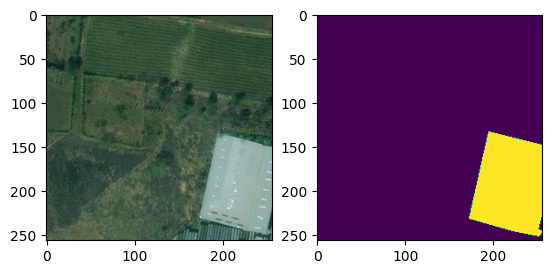

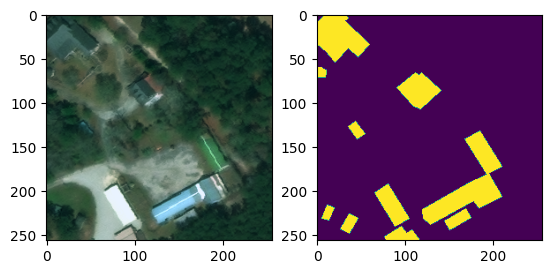

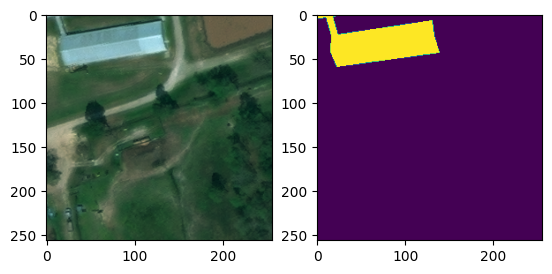

In [20]:
visualize_sample(train_dataset)
visualize_sample(val_dataset)
visualize_sample(test_dataset)

CPUs:

In [21]:
os.cpu_count()

8

GPUs:

In [22]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-40f4c87c-4b97-c7f1-7bc7-88a51803976b)


In [23]:
!nvidia-smi

Fri Jan 19 12:27:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Experiment 1

* Architecture: UNET
* Backbone: **resnext50_32x4d**
* pretrained: **Imagenet**
* no freezed
* Loss: Jaccardi
* Metric: DICE coef
* Epochs: 50
* Batch size: 32
* T/V/V: 0.7/0.15/0.15 seed=42
* Early stopping with patience: 10


## Train - Validate

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)


# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.5245, Training Metric: 0.6666
Validation Loss: 0.4383, Validation Metric: 0.7176
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4151, Training Metric: 0.7382
Validation Loss: 0.4083, Validation Metric: 0.7416
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4001, Training Metric: 0.7495
Validation Loss: 0.3786, Validation Metric: 0.7646
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3864, Training Metric: 0.7599
Validation Loss: 0.3581, Validation Metric: 0.7796
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3791, Training Metric: 0.7655
Validation Loss: 0.3701, Validation Metric: 0.7698
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3685, Training Metric: 0.7733
Validation Loss: 0.3558, Validation Metric: 0.7804
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3681, Training Metric: 0.7736
Validation Loss: 0.3501, Validation Metric: 0.7852
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3614, Training Metric: 0.7788
Validation Loss: 0.3764, Validation Metric: 0.7652
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3561, Training Metric: 0.7826
Validation Loss: 0.3309, Validation Metric: 0.7996
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3501, Training Metric: 0.7872
Validation Loss: 0.3293, Validation Metric: 0.8005
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3467, Training Metric: 0.7897
Validation Loss: 0.3432, Validation Metric: 0.7902
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3472, Training Metric: 0.7892
Validation Loss: 0.3445, Validation Metric: 0.7894
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3443, Training Metric: 0.7913
Validation Loss: 0.3182, Validation Metric: 0.8083
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3421, Training Metric: 0.7930
Validation Loss: 0.3120, Validation Metric: 0.8130
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3420, Training Metric: 0.7929
Validation Loss: 0.3282, Validation Metric: 0.8004
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3352, Training Metric: 0.7979
Validation Loss: 0.3135, Validation Metric: 0.8120
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3291, Training Metric: 0.8024
Validation Loss: 0.3099, Validation Metric: 0.8144
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3308, Training Metric: 0.8012
Validation Loss: 0.3105, Validation Metric: 0.8140
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3262, Training Metric: 0.8045
Validation Loss: 0.3094, Validation Metric: 0.8144
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3254, Training Metric: 0.8051
Validation Loss: 0.3098, Validation Metric: 0.8142
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3217, Training Metric: 0.8077
Validation Loss: 0.3184, Validation Metric: 0.8079
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3247, Training Metric: 0.8056
Validation Loss: 0.3048, Validation Metric: 0.8182
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3229, Training Metric: 0.8069
Validation Loss: 0.3057, Validation Metric: 0.8171
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3177, Training Metric: 0.8105
Validation Loss: 0.3090, Validation Metric: 0.8149
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3243, Training Metric: 0.8057
Validation Loss: 0.3205, Validation Metric: 0.8068
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3200, Training Metric: 0.8089
Validation Loss: 0.3033, Validation Metric: 0.8191
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3116, Training Metric: 0.8149
Validation Loss: 0.2988, Validation Metric: 0.8222
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3186, Training Metric: 0.8099
Validation Loss: 0.3020, Validation Metric: 0.8201
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3183, Training Metric: 0.8101
Validation Loss: 0.3055, Validation Metric: 0.8177
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3126, Training Metric: 0.8141
Validation Loss: 0.2977, Validation Metric: 0.8232
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3130, Training Metric: 0.8138
Validation Loss: 0.2985, Validation Metric: 0.8223
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3119, Training Metric: 0.8146
Validation Loss: 0.3030, Validation Metric: 0.8193
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3075, Training Metric: 0.8178
Validation Loss: 0.2890, Validation Metric: 0.8291
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3055, Training Metric: 0.8192
Validation Loss: 0.3013, Validation Metric: 0.8202
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3088, Training Metric: 0.8168
Validation Loss: 0.2858, Validation Metric: 0.8311
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3041, Training Metric: 0.8201
Validation Loss: 0.2925, Validation Metric: 0.8266
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3033, Training Metric: 0.8207
Validation Loss: 0.2915, Validation Metric: 0.8272
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3054, Training Metric: 0.8193
Validation Loss: 0.2876, Validation Metric: 0.8299
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3030, Training Metric: 0.8209
Validation Loss: 0.3025, Validation Metric: 0.8188
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3048, Training Metric: 0.8196
Validation Loss: 0.2898, Validation Metric: 0.8282
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2990, Training Metric: 0.8237
Validation Loss: 0.2877, Validation Metric: 0.8301
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 6


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3000, Training Metric: 0.8230
Validation Loss: 0.2897, Validation Metric: 0.8284
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 7


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3028, Training Metric: 0.8210
Validation Loss: 0.2849, Validation Metric: 0.8317
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3008, Training Metric: 0.8224
Validation Loss: 0.2926, Validation Metric: 0.8266
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2998, Training Metric: 0.8231
Validation Loss: 0.2848, Validation Metric: 0.8322
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2960, Training Metric: 0.8257
Validation Loss: 0.2834, Validation Metric: 0.8330
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2969, Training Metric: 0.8252
Validation Loss: 0.2908, Validation Metric: 0.8277
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2957, Training Metric: 0.8260
Validation Loss: 0.2825, Validation Metric: 0.8336
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2911, Training Metric: 0.8292
Validation Loss: 0.2788, Validation Metric: 0.8361
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/best_model.pth
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2956, Training Metric: 0.8260
Validation Loss: 0.2789, Validation Metric: 0.8360
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet/final_model.pth


In [ ]:
training_loss = [0.5245, 0.4151, 0.4001, 0.3864, 0.3791, 0.3685, 0.3681, 0.3614, 0.3561, 0.3501, 0.3467, 0.3472, 0.3443, 0.3421, 0.3420, 0.3352, 0.3291, 0.3308, 0.3262, 0.3254, 0.3217, 0.3247, 0.3229, 0.3177, 0.3243, 0.3200, 0.3116, 0.3186, 0.3183, 0.3126, 0.3130, 0.3119, 0.3075, 0.3055, 0.3088, 0.3041, 0.3033, 0.3054, 0.3030, 0.3048, 0.2990, 0.3000, 0.3028, 0.3008, 0.2998, 0.2960, 0.2969, 0.2957, 0.2911, 0.2956]
validation_loss = [0.4383, 0.4083, 0.3786, 0.3581, 0.3701, 0.3558, 0.3501, 0.3764, 0.3309, 0.3293, 0.3432, 0.3445, 0.3182, 0.3120, 0.3282, 0.3135, 0.3099, 0.3105, 0.3094, 0.3098, 0.3184, 0.3048, 0.3057, 0.3090, 0.3205, 0.3033, 0.2988, 0.3020, 0.3055, 0.2977, 0.2985, 0.3030, 0.2890, 0.3013, 0.2858, 0.2925, 0.2915, 0.2876, 0.3025, 0.2898, 0.2877, 0.2897, 0.2849, 0.2926, 0.2848, 0.2834, 0.2908, 0.2825, 0.2788, 0.2789]
training_metric = [0.6666, 0.7382, 0.7495, 0.7599, 0.7655, 0.7733, 0.7736, 0.7788, 0.7826, 0.7872, 0.7897, 0.7892, 0.7913, 0.7930, 0.7929, 0.7979, 0.8024, 0.8012, 0.8045, 0.8051, 0.8077, 0.8056, 0.8069, 0.8105, 0.8057, 0.8089, 0.8149, 0.8099, 0.8101, 0.8141, 0.8138, 0.8146, 0.8178, 0.8192, 0.8168, 0.8201, 0.8207, 0.8193, 0.8209, 0.8196, 0.8237, 0.8230, 0.8210, 0.8224, 0.8231, 0.8257, 0.8252, 0.8260, 0.8292, 0.8260]
validation_metric = [0.7176, 0.7416, 0.7646, 0.7796, 0.7698, 0.7804, 0.7852, 0.7652, 0.7996, 0.8005, 0.7902, 0.7894, 0.8083, 0.8130, 0.8004, 0.8120, 0.8144, 0.8140, 0.8144, 0.8142, 0.8079, 0.8182, 0.8171, 0.8149, 0.8068, 0.8191, 0.8222, 0.8201, 0.8177, 0.8232, 0.8223, 0.8193, 0.8291, 0.8202, 0.8311, 0.8266, 0.8272, 0.8299, 0.8188, 0.8282, 0.8301, 0.8284, 0.8317, 0.8266, 0.8322, 0.8330, 0.8277, 0.8336, 0.8361, 0.8360]

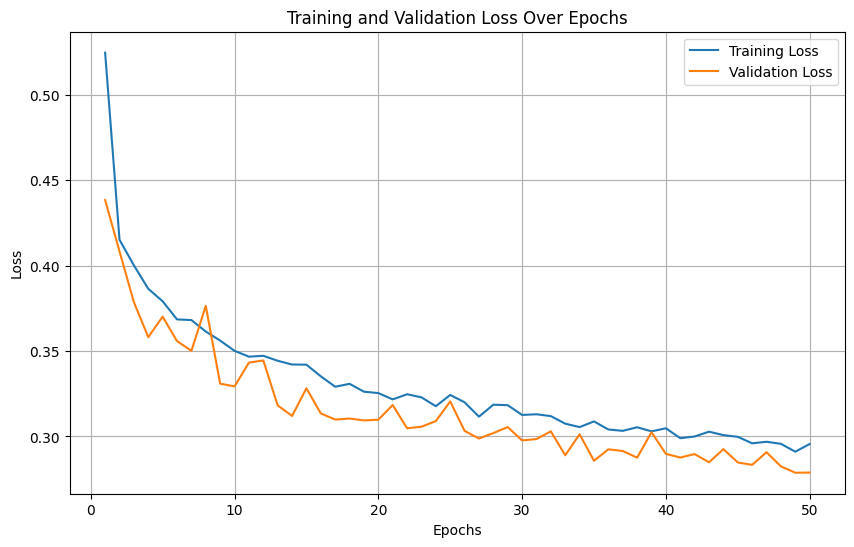

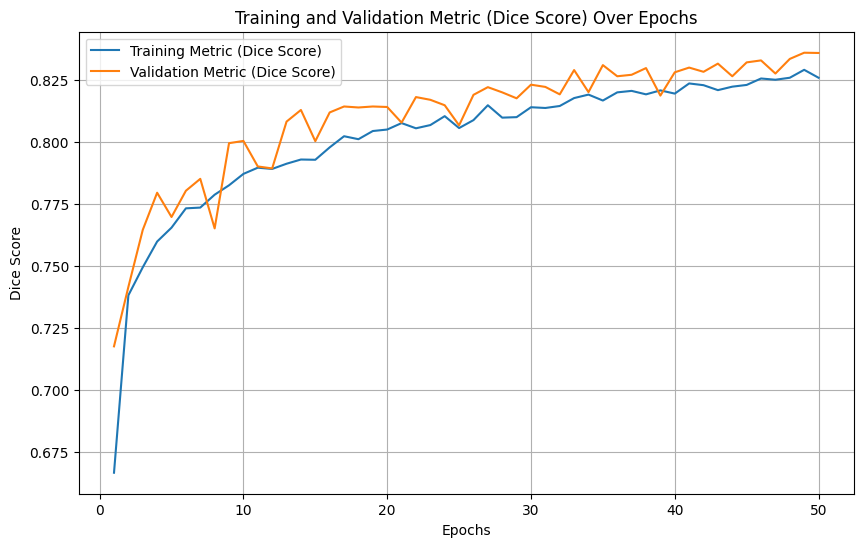

In [ ]:
loss_filename, metric_filename = plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='unet_resnext50_32x4d_no_freezed')

## Test

In [24]:
archi = 'unet'
backbone = 'resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
model_path = path + "/best_model.pth"
model = load_model_weights(model, model_path, device)

In [26]:
n_cpu = 8
batch_size = 32
test_dataset = BuildingDataset("/content/test_images/test", "/content/test_masks/test", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [27]:
metrics = compute_metrics(model, test_dataloader, device)
print("Model Metrics:", metrics)

Evaluating:   0%|          | 0/259 [00:00<?, ?it/s]

Model Metrics: {'accuracy': 0.9660721948248079, 'iou': 0.8387319272736882}


In [29]:
visualize_predictions_and_explain(model, test_dataloader, num_images=50, device=device, seed =24, title = folder , save_path=path+'/explain/')

Output hidden; open in https://colab.research.google.com to view.

# Experiment 1b

* Architecture: UNET
* Backbone: **resnext50_32x4d**
* pretrained: **Imagenet**
* FREEZED
* Loss: Jaccardi
* Metric: DICE coef
* Epochs: 50
* Batch size: 32
* T/V/V: 0.7/0.15/0.15 seed=42
* Early stopping with patience: 10


## Train - Validate

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}_b'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)

# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

for param in model.encoder.parameters():
    param.requires_grad = False

# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.5248, Training Metric: 0.6645
Validation Loss: 0.4046, Validation Metric: 0.7466
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4109, Training Metric: 0.7422
Validation Loss: 0.3773, Validation Metric: 0.7661
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3828, Training Metric: 0.7634
Validation Loss: 0.3428, Validation Metric: 0.7916
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3662, Training Metric: 0.7757
Validation Loss: 0.3406, Validation Metric: 0.7929
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3568, Training Metric: 0.7826
Validation Loss: 0.3304, Validation Metric: 0.8003
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3506, Training Metric: 0.7871
Validation Loss: 0.3271, Validation Metric: 0.8025
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3451, Training Metric: 0.7911
Validation Loss: 0.3226, Validation Metric: 0.8059
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3393, Training Metric: 0.7954
Validation Loss: 0.3171, Validation Metric: 0.8098
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3334, Training Metric: 0.7996
Validation Loss: 0.3169, Validation Metric: 0.8096
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3294, Training Metric: 0.8025
Validation Loss: 0.3076, Validation Metric: 0.8165
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3272, Training Metric: 0.8041
Validation Loss: 0.3155, Validation Metric: 0.8108
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3233, Training Metric: 0.8068
Validation Loss: 0.3080, Validation Metric: 0.8162
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3204, Training Metric: 0.8089
Validation Loss: 0.3040, Validation Metric: 0.8190
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3197, Training Metric: 0.8093
Validation Loss: 0.2994, Validation Metric: 0.8222
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3177, Training Metric: 0.8107
Validation Loss: 0.3009, Validation Metric: 0.8212
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3149, Training Metric: 0.8128
Validation Loss: 0.2965, Validation Metric: 0.8242
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3127, Training Metric: 0.8143
Validation Loss: 0.2969, Validation Metric: 0.8240
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3115, Training Metric: 0.8152
Validation Loss: 0.2958, Validation Metric: 0.8247
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3097, Training Metric: 0.8164
Validation Loss: 0.2988, Validation Metric: 0.8225
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3078, Training Metric: 0.8178
Validation Loss: 0.2953, Validation Metric: 0.8249
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3069, Training Metric: 0.8184
Validation Loss: 0.2957, Validation Metric: 0.8245
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3062, Training Metric: 0.8189
Validation Loss: 0.2917, Validation Metric: 0.8275
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3038, Training Metric: 0.8205
Validation Loss: 0.2940, Validation Metric: 0.8260
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3049, Training Metric: 0.8197
Validation Loss: 0.2925, Validation Metric: 0.8271
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3028, Training Metric: 0.8213
Validation Loss: 0.2892, Validation Metric: 0.8292
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3003, Training Metric: 0.8230
Validation Loss: 0.2880, Validation Metric: 0.8301
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2987, Training Metric: 0.8241
Validation Loss: 0.2936, Validation Metric: 0.8262
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2989, Training Metric: 0.8240
Validation Loss: 0.2854, Validation Metric: 0.8319
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2978, Training Metric: 0.8247
Validation Loss: 0.2815, Validation Metric: 0.8346
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2976, Training Metric: 0.8248
Validation Loss: 0.2855, Validation Metric: 0.8318
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2951, Training Metric: 0.8265
Validation Loss: 0.2833, Validation Metric: 0.8333
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2942, Training Metric: 0.8271
Validation Loss: 0.2853, Validation Metric: 0.8318
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2950, Training Metric: 0.8267
Validation Loss: 0.2820, Validation Metric: 0.8343
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2949, Training Metric: 0.8267
Validation Loss: 0.2820, Validation Metric: 0.8342
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2935, Training Metric: 0.8276
Validation Loss: 0.2814, Validation Metric: 0.8345
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2921, Training Metric: 0.8286
Validation Loss: 0.2776, Validation Metric: 0.8372
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2915, Training Metric: 0.8290
Validation Loss: 0.2856, Validation Metric: 0.8319
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2903, Training Metric: 0.8298
Validation Loss: 0.2786, Validation Metric: 0.8365
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2901, Training Metric: 0.8300
Validation Loss: 0.2799, Validation Metric: 0.8356
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2885, Training Metric: 0.8311
Validation Loss: 0.2820, Validation Metric: 0.8343
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2887, Training Metric: 0.8309
Validation Loss: 0.2778, Validation Metric: 0.8372
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2880, Training Metric: 0.8314
Validation Loss: 0.2772, Validation Metric: 0.8375
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2878, Training Metric: 0.8315
Validation Loss: 0.2740, Validation Metric: 0.8398
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2876, Training Metric: 0.8317
Validation Loss: 0.2779, Validation Metric: 0.8370
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2876, Training Metric: 0.8317
Validation Loss: 0.2787, Validation Metric: 0.8364
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2859, Training Metric: 0.8329
Validation Loss: 0.2739, Validation Metric: 0.8397
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2853, Training Metric: 0.8332
Validation Loss: 0.2738, Validation Metric: 0.8398
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2851, Training Metric: 0.8334
Validation Loss: 0.2749, Validation Metric: 0.8390
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2861, Training Metric: 0.8327
Validation Loss: 0.2720, Validation Metric: 0.8410
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/best_model.pth
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2842, Training Metric: 0.8340
Validation Loss: 0.2746, Validation Metric: 0.8391
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_imagenet_b/final_model.pth


In [ ]:
# Training and validation metrics for each epoch
training_loss = [
    0.5248, 0.4109, 0.3828, 0.3662, 0.3568, 0.3506, 0.3451, 0.3393, 0.3334, 0.3294,
    0.3272, 0.3233, 0.3204, 0.3197, 0.3177, 0.3149, 0.3127, 0.3115, 0.3097, 0.3078,
    0.3069, 0.3062, 0.3038, 0.3049, 0.3028, 0.3003, 0.2987, 0.2989, 0.2978, 0.2976,
    0.2951, 0.2942, 0.2950, 0.2949, 0.2935, 0.2921, 0.2915, 0.2903, 0.2901, 0.2885,
    0.2887, 0.2880, 0.2878, 0.2876, 0.2876, 0.2859, 0.2853, 0.2851, 0.2861, 0.2842
]
training_metric = [
    0.6645, 0.7422, 0.7634, 0.7757, 0.7826, 0.7871, 0.7911, 0.7954, 0.7996, 0.8025,
    0.8041, 0.8068, 0.8089, 0.8093, 0.8107, 0.8128, 0.8143, 0.8152, 0.8164, 0.8178,
    0.8184, 0.8189, 0.8205, 0.8197, 0.8213, 0.8230, 0.8241, 0.8240, 0.8247, 0.8248,
    0.8265, 0.8271, 0.8267, 0.8267, 0.8276, 0.8286, 0.8290, 0.8298, 0.8300, 0.8311,
    0.8309, 0.8314, 0.8315, 0.8317, 0.8317, 0.8329, 0.8332, 0.8334, 0.8327, 0.8340
]
validation_loss = [
    0.4046, 0.3773, 0.3428, 0.3406, 0.3304, 0.3271, 0.3226, 0.3171, 0.3169, 0.3076,
    0.3155, 0.3080, 0.3040, 0.2994, 0.3009, 0.2965, 0.2969, 0.2958, 0.2988, 0.2953,
    0.2957, 0.2917, 0.2940, 0.2925, 0.2892, 0.2880, 0.2936, 0.2854, 0.2815, 0.2855,
    0.2833, 0.2853, 0.2820, 0.2820, 0.2814, 0.2776, 0.2856, 0.2786, 0.2799, 0.2820,
    0.2778, 0.2772, 0.2740, 0.2779, 0.2787, 0.2739, 0.2738, 0.2749, 0.2720, 0.2746
]
validation_metric = [
    0.7466, 0.7661, 0.7916, 0.7929, 0.8003, 0.8025, 0.8059, 0.8098, 0.8096, 0.8165,
    0.8108, 0.8162, 0.8190, 0.8222, 0.8212, 0.8242, 0.8240, 0.8247, 0.8225, 0.8249,
    0.8245, 0.8275, 0.8260, 0.8271, 0.8292, 0.8301, 0.8262, 0.8319, 0.8346, 0.8318,
    0.8333, 0.8318, 0.8343, 0.8342, 0.8345, 0.8372, 0.8319, 0.8365, 0.8356, 0.8343,
    0.8372, 0.8375, 0.8398, 0.8370, 0.8364, 0.8397, 0.8398, 0.8390, 0.8410, 0.8391
]

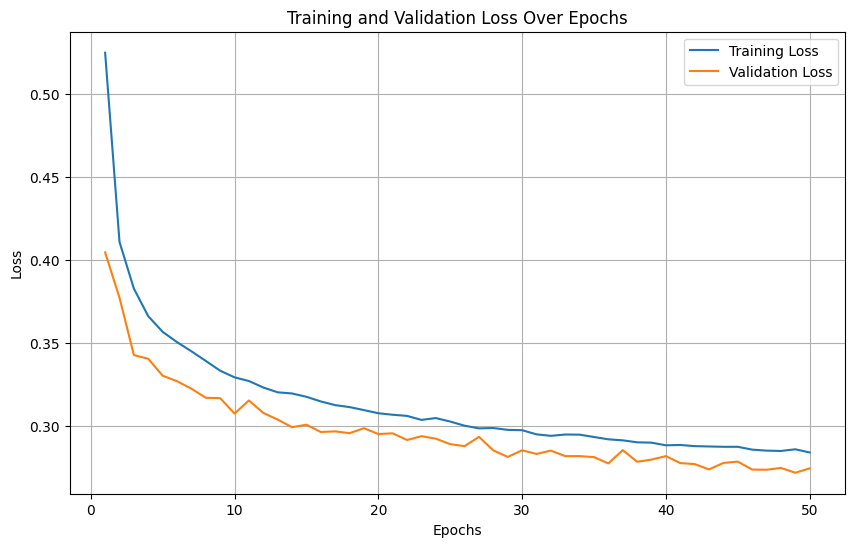

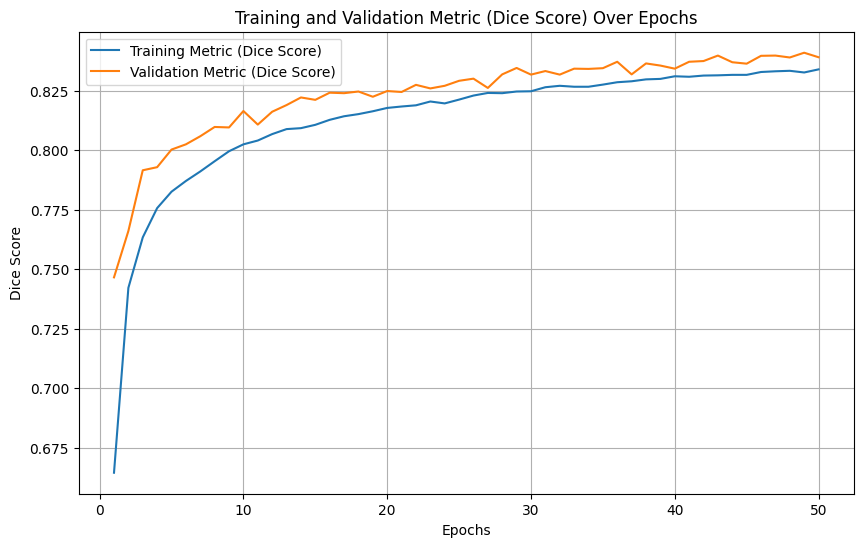

In [ ]:
# plot_loss_metric(training_loss,validation_loss,training_metric,validation_metric)
loss_filename, metric_filename = plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='unet_resnext50_32x4d_freezed')

## Test

In [30]:
archi = 'unet'
backbone = 'resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}_b'
path =f'/content/drive/MyDrive/{folder}'

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
model_path = path + "/best_model.pth"
model = load_model_weights(model, model_path, device)

In [ ]:
n_cpu = 8
batch_size = 32
test_dataset = BuildingDataset("/content/test_images/test", "/content/test_masks/test", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [32]:
metrics = compute_metrics(model, test_dataloader, device)
print("Model Metrics:", metrics)

Evaluating:   0%|          | 0/259 [00:00<?, ?it/s]

Model Metrics: {'accuracy': 0.9663488763639826, 'iou': 0.8406324562490264}


In [34]:
visualize_predictions_and_explain(model, test_dataloader, num_images=50, device=device, seed =24, title = folder , save_path=path+'/explain/')

Output hidden; open in https://colab.research.google.com to view.

# Experiment 2

* Architecture: UNET
* Backbone: **resnet50**
* pretrained: **Imagenet**
* no freezed
* Loss: Jaccardi
* Metric: DICE coef
* Epochs: 50
* Batch size: 32
* T/V/V: 0.7/0.15/0.15 seed=42
* Early stopping with patience: 10


## Train - Validate

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)

# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.5343, Training Metric: 0.6446
Validation Loss: 0.4350, Validation Metric: 0.7203
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4434, Training Metric: 0.7148
Validation Loss: 0.4028, Validation Metric: 0.7445
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4239, Training Metric: 0.7304
Validation Loss: 0.4003, Validation Metric: 0.7452
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4156, Training Metric: 0.7367
Validation Loss: 0.3731, Validation Metric: 0.7684
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4004, Training Metric: 0.7489
Validation Loss: 0.3653, Validation Metric: 0.7739
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3976, Training Metric: 0.7509
Validation Loss: 0.3960, Validation Metric: 0.7503
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3953, Training Metric: 0.7527
Validation Loss: 0.3499, Validation Metric: 0.7853
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3816, Training Metric: 0.7635
Validation Loss: 0.3637, Validation Metric: 0.7753
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3725, Training Metric: 0.7704
Validation Loss: 0.3455, Validation Metric: 0.7882
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3717, Training Metric: 0.7710
Validation Loss: 0.3639, Validation Metric: 0.7742
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3688, Training Metric: 0.7732
Validation Loss: 0.3372, Validation Metric: 0.7948
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3646, Training Metric: 0.7762
Validation Loss: 0.3377, Validation Metric: 0.7944
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3649, Training Metric: 0.7760
Validation Loss: 0.3440, Validation Metric: 0.7889
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3581, Training Metric: 0.7812
Validation Loss: 0.3401, Validation Metric: 0.7924
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3595, Training Metric: 0.7801
Validation Loss: 0.3420, Validation Metric: 0.7911
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3549, Training Metric: 0.7835
Validation Loss: 0.3308, Validation Metric: 0.7990
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3487, Training Metric: 0.7881
Validation Loss: 0.3388, Validation Metric: 0.7932
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3474, Training Metric: 0.7891
Validation Loss: 0.3308, Validation Metric: 0.7987
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3484, Training Metric: 0.7883
Validation Loss: 0.3221, Validation Metric: 0.8057
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3457, Training Metric: 0.7903
Validation Loss: 0.3212, Validation Metric: 0.8063
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3516, Training Metric: 0.7859
Validation Loss: 0.3237, Validation Metric: 0.8039
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3377, Training Metric: 0.7963
Validation Loss: 0.3322, Validation Metric: 0.7980
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3448, Training Metric: 0.7909
Validation Loss: 0.3171, Validation Metric: 0.8092
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3333, Training Metric: 0.7994
Validation Loss: 0.3201, Validation Metric: 0.8071
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3317, Training Metric: 0.8004
Validation Loss: 0.3189, Validation Metric: 0.8081
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3345, Training Metric: 0.7983
Validation Loss: 0.3322, Validation Metric: 0.7983
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3344, Training Metric: 0.7986
Validation Loss: 0.3180, Validation Metric: 0.8086
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3331, Training Metric: 0.7995
Validation Loss: 0.3183, Validation Metric: 0.8081
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3263, Training Metric: 0.8044
Validation Loss: 0.3148, Validation Metric: 0.8109
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3294, Training Metric: 0.8022
Validation Loss: 0.3130, Validation Metric: 0.8121
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3226, Training Metric: 0.8071
Validation Loss: 0.3148, Validation Metric: 0.8107
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3230, Training Metric: 0.8067
Validation Loss: 0.3444, Validation Metric: 0.7893
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3267, Training Metric: 0.8040
Validation Loss: 0.3133, Validation Metric: 0.8117
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3196, Training Metric: 0.8092
Validation Loss: 0.3122, Validation Metric: 0.8128
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3268, Training Metric: 0.8040
Validation Loss: 0.3171, Validation Metric: 0.8093
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3221, Training Metric: 0.8074
Validation Loss: 0.3023, Validation Metric: 0.8196
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3165, Training Metric: 0.8114
Validation Loss: 0.3103, Validation Metric: 0.8138
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3182, Training Metric: 0.8102
Validation Loss: 0.3130, Validation Metric: 0.8120
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3188, Training Metric: 0.8097
Validation Loss: 0.3043, Validation Metric: 0.8182
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3218, Training Metric: 0.8075
Validation Loss: 0.3045, Validation Metric: 0.8182
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3143, Training Metric: 0.8130
Validation Loss: 0.2952, Validation Metric: 0.8248
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3191, Training Metric: 0.8095
Validation Loss: 0.3263, Validation Metric: 0.8021
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3197, Training Metric: 0.8091
Validation Loss: 0.2961, Validation Metric: 0.8240
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3116, Training Metric: 0.8149
Validation Loss: 0.3065, Validation Metric: 0.8160
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3126, Training Metric: 0.8141
Validation Loss: 0.3080, Validation Metric: 0.8155
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3191, Training Metric: 0.8095
Validation Loss: 0.3104, Validation Metric: 0.8142
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3099, Training Metric: 0.8161
Validation Loss: 0.2943, Validation Metric: 0.8252
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/best_model.pth
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3097, Training Metric: 0.8162
Validation Loss: 0.3046, Validation Metric: 0.8179
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3093, Training Metric: 0.8165
Validation Loss: 0.3038, Validation Metric: 0.8188
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3091, Training Metric: 0.8166
Validation Loss: 0.3038, Validation Metric: 0.8188
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet/final_model.pth


In [ ]:
training_loss = [
    0.5343, 0.4434, 0.4239, 0.4156, 0.4004, 0.3976, 0.3953, 0.3816, 0.3725, 0.3717,
    0.3688, 0.3646, 0.3649, 0.3581, 0.3595, 0.3549, 0.3487, 0.3474, 0.3484, 0.3457,
    0.3516, 0.3377, 0.3448, 0.3333, 0.3317, 0.3345, 0.3344, 0.3331, 0.3263, 0.3294,
    0.3226, 0.3230, 0.3267, 0.3196, 0.3268, 0.3221, 0.3165, 0.3182, 0.3188, 0.3218,
    0.3143, 0.3191, 0.3197, 0.3116, 0.3126, 0.3191, 0.3099, 0.3097, 0.3093, 0.3091
]

validation_loss = [
    0.4350, 0.4028, 0.4003, 0.3731, 0.3653, 0.3960, 0.3499, 0.3637, 0.3455, 0.3639,
    0.3372, 0.3377, 0.3440, 0.3401, 0.3420, 0.3308, 0.3388, 0.3308, 0.3221, 0.3212,
    0.3237, 0.3322, 0.3171, 0.3201, 0.3189, 0.3322, 0.3180, 0.3183, 0.3148, 0.3130,
    0.3148, 0.3444, 0.3133, 0.3122, 0.3171, 0.3023, 0.3103, 0.3130, 0.3043, 0.3045,
    0.2952, 0.3263, 0.2961, 0.3065, 0.3080, 0.3104, 0.2943, 0.3046, 0.3038, 0.3038
]

training_metric = [
    0.6446, 0.7148, 0.7304, 0.7367, 0.7489, 0.7509, 0.7527, 0.7635, 0.7704, 0.7710,
    0.7732, 0.7762, 0.7760, 0.7812, 0.7801, 0.7835, 0.7881, 0.7891, 0.7883, 0.7903,
    0.7859, 0.7963, 0.7909, 0.7994, 0.8004, 0.7983, 0.7986, 0.7995, 0.8044, 0.8022,
    0.8071, 0.8067, 0.8040, 0.8092, 0.8040, 0.8074, 0.8114, 0.8102, 0.8097, 0.8075,
    0.8130, 0.8095, 0.8091, 0.8149, 0.8141, 0.8095, 0.8161, 0.8162, 0.8165, 0.8166
]

validation_metric = [
    0.7203, 0.7445, 0.7452, 0.7684, 0.7739, 0.7503, 0.7853, 0.7753, 0.7882, 0.7742,
    0.7948, 0.7944, 0.7889, 0.7924, 0.7911, 0.7990, 0.7932, 0.7987, 0.8057, 0.8063,
    0.8039, 0.7980, 0.8092, 0.8071, 0.8081, 0.7983, 0.8086, 0.8081, 0.8109, 0.8121,
    0.8107, 0.7893, 0.8117, 0.8128, 0.8093, 0.8196, 0.8138, 0.8120, 0.8182, 0.8182,
    0.8248, 0.8021, 0.8240, 0.8160, 0.8155, 0.8142, 0.8252, 0.8179, 0.8188, 0.8188
]

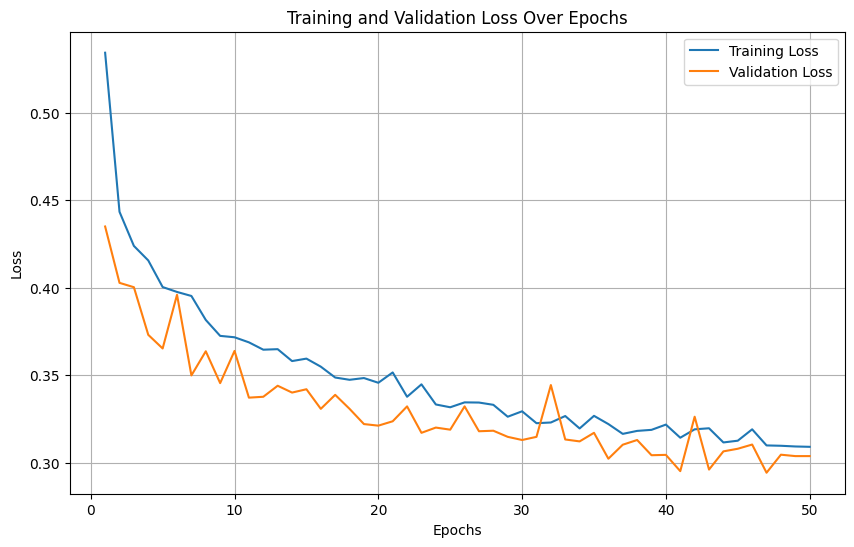

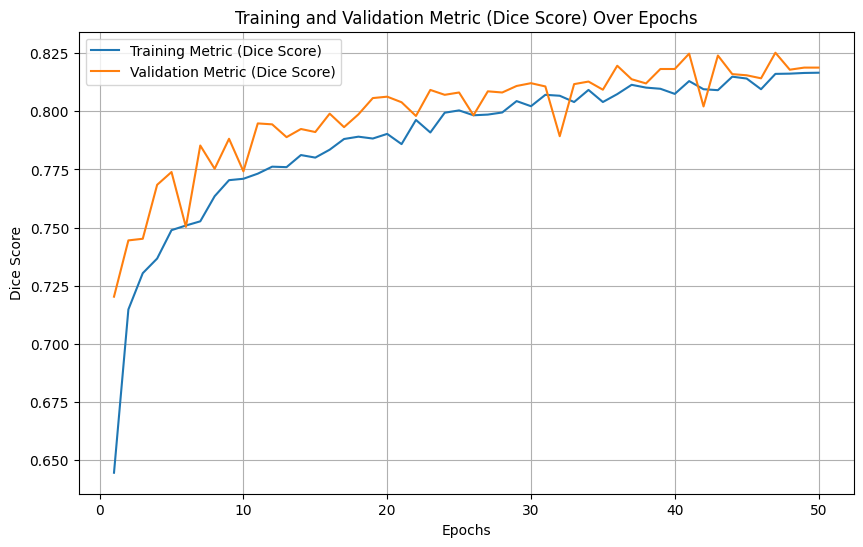

In [ ]:
# plot_loss_metric(training_loss,validation_loss,training_metric,validation_metric)
loss_filename, metric_filename = plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='unet_resnet50_no_freezed')

## Test

In [35]:
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
model_path = path + "/best_model.pth"
model = load_model_weights(model, model_path, device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 384MB/s]


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [37]:
metrics = compute_metrics(model, test_dataloader, device)
print("Model Metrics:", metrics)

Evaluating:   0%|          | 0/259 [00:00<?, ?it/s]

Model Metrics: {'accuracy': 0.9650793940864475, 'iou': 0.8323332151367043}


In [38]:
visualize_predictions_and_explain(model, test_dataloader, num_images=50, device=device, seed =24, title = folder , save_path=path+'/explain/')

Output hidden; open in https://colab.research.google.com to view.

# Experiment 2b

* Architecture: UNET
* Backbone: **resnet50**
* pretrained: **Imagenet**
* FREEZED
* Loss: Jaccardi
* Metric: DICE coef
* Epochs: 50
* Batch size: 32
* T/V/V: 0.7/0.15/0.15 seed=42
* Early stopping with patience: 10

## Train - Validate

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}_b'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)

# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

for param in model.encoder.parameters():
    param.requires_grad = False

# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.5391, Training Metric: 0.6523
Validation Loss: 0.4268, Validation Metric: 0.7290
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4162, Training Metric: 0.7377
Validation Loss: 0.3820, Validation Metric: 0.7620
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3930, Training Metric: 0.7553
Validation Loss: 0.3632, Validation Metric: 0.7756
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3750, Training Metric: 0.7689
Validation Loss: 0.3608, Validation Metric: 0.7780
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3675, Training Metric: 0.7744
Validation Loss: 0.3491, Validation Metric: 0.7864
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3597, Training Metric: 0.7803
Validation Loss: 0.3567, Validation Metric: 0.7811
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3524, Training Metric: 0.7858
Validation Loss: 0.3273, Validation Metric: 0.8024
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3477, Training Metric: 0.7892
Validation Loss: 0.3317, Validation Metric: 0.7991
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3432, Training Metric: 0.7924
Validation Loss: 0.3237, Validation Metric: 0.8050
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3385, Training Metric: 0.7959
Validation Loss: 0.3237, Validation Metric: 0.8050
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3370, Training Metric: 0.7969
Validation Loss: 0.3182, Validation Metric: 0.8088
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3339, Training Metric: 0.7992
Validation Loss: 0.3158, Validation Metric: 0.8108
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3294, Training Metric: 0.8024
Validation Loss: 0.3163, Validation Metric: 0.8104
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3269, Training Metric: 0.8042
Validation Loss: 0.3125, Validation Metric: 0.8132
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3242, Training Metric: 0.8061
Validation Loss: 0.3107, Validation Metric: 0.8143
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3221, Training Metric: 0.8076
Validation Loss: 0.3080, Validation Metric: 0.8163
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3203, Training Metric: 0.8090
Validation Loss: 0.3035, Validation Metric: 0.8194
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3196, Training Metric: 0.8094
Validation Loss: 0.3034, Validation Metric: 0.8194
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3167, Training Metric: 0.8115
Validation Loss: 0.3051, Validation Metric: 0.8179
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3158, Training Metric: 0.8121
Validation Loss: 0.3046, Validation Metric: 0.8185
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3131, Training Metric: 0.8140
Validation Loss: 0.2964, Validation Metric: 0.8244
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3133, Training Metric: 0.8139
Validation Loss: 0.2980, Validation Metric: 0.8233
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3125, Training Metric: 0.8144
Validation Loss: 0.2973, Validation Metric: 0.8235
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3107, Training Metric: 0.8157
Validation Loss: 0.2968, Validation Metric: 0.8239
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3101, Training Metric: 0.8161
Validation Loss: 0.2966, Validation Metric: 0.8240
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3090, Training Metric: 0.8168
Validation Loss: 0.2940, Validation Metric: 0.8260
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3072, Training Metric: 0.8181
Validation Loss: 0.2915, Validation Metric: 0.8277
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3060, Training Metric: 0.8189
Validation Loss: 0.2948, Validation Metric: 0.8255
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3050, Training Metric: 0.8196
Validation Loss: 0.2912, Validation Metric: 0.8277
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3046, Training Metric: 0.8199
Validation Loss: 0.2923, Validation Metric: 0.8271
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3039, Training Metric: 0.8204
Validation Loss: 0.2901, Validation Metric: 0.8287
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3037, Training Metric: 0.8205
Validation Loss: 0.2883, Validation Metric: 0.8299
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3006, Training Metric: 0.8227
Validation Loss: 0.2915, Validation Metric: 0.8275
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3011, Training Metric: 0.8224
Validation Loss: 0.2901, Validation Metric: 0.8286
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2998, Training Metric: 0.8233
Validation Loss: 0.2914, Validation Metric: 0.8274
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2988, Training Metric: 0.8240
Validation Loss: 0.2877, Validation Metric: 0.8303
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2974, Training Metric: 0.8249
Validation Loss: 0.2855, Validation Metric: 0.8318
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2970, Training Metric: 0.8251
Validation Loss: 0.2838, Validation Metric: 0.8329
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2969, Training Metric: 0.8253
Validation Loss: 0.2826, Validation Metric: 0.8338
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2970, Training Metric: 0.8252
Validation Loss: 0.2819, Validation Metric: 0.8344
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2955, Training Metric: 0.8263
Validation Loss: 0.2822, Validation Metric: 0.8340
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2947, Training Metric: 0.8268
Validation Loss: 0.2784, Validation Metric: 0.8367
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2959, Training Metric: 0.8259
Validation Loss: 0.2874, Validation Metric: 0.8306
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2934, Training Metric: 0.8276
Validation Loss: 0.2815, Validation Metric: 0.8346
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2934, Training Metric: 0.8277
Validation Loss: 0.2850, Validation Metric: 0.8321
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2930, Training Metric: 0.8279
Validation Loss: 0.2784, Validation Metric: 0.8367
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2914, Training Metric: 0.8291
Validation Loss: 0.2796, Validation Metric: 0.8359
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2921, Training Metric: 0.8286
Validation Loss: 0.2827, Validation Metric: 0.8337
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 6


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2915, Training Metric: 0.8290
Validation Loss: 0.2840, Validation Metric: 0.8328
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 7


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2912, Training Metric: 0.8292
Validation Loss: 0.2782, Validation Metric: 0.8368
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/best_model.pth
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_resnet50_imagenet_b/final_model.pth


In [ ]:
training_loss = [
    0.5391, 0.4162, 0.3930, 0.3750, 0.3675, 0.3597, 0.3524, 0.3477, 0.3432,
    0.3385, 0.3370, 0.3339, 0.3294, 0.3269, 0.3242, 0.3221, 0.3203, 0.3196,
    0.3167, 0.3158, 0.3131, 0.3133, 0.3125, 0.3107, 0.3101, 0.3090, 0.3072,
    0.3060, 0.3050, 0.3046, 0.3039, 0.3037, 0.3006, 0.3011, 0.2998, 0.2988,
    0.2974, 0.2970, 0.2969, 0.2970, 0.2955, 0.2947, 0.2959, 0.2934, 0.2934,
    0.2930, 0.2914, 0.2921, 0.2915, 0.2912
]
validation_loss = [
    0.4268, 0.3820, 0.3632, 0.3608, 0.3491, 0.3567, 0.3273, 0.3317, 0.3237,
    0.3237, 0.3182, 0.3158, 0.3163, 0.3125, 0.3107, 0.3080, 0.3035, 0.3034,
    0.3051, 0.3046, 0.2964, 0.2980, 0.2973, 0.2968, 0.2966, 0.2940, 0.2915,
    0.2948, 0.2912, 0.2923, 0.2901, 0.2883, 0.2915, 0.2901, 0.2914, 0.2877,
    0.2855, 0.2838, 0.2826, 0.2819, 0.2822, 0.2784, 0.2874, 0.2815, 0.2850,
    0.2784, 0.2796, 0.2827, 0.2840, 0.2782
]
training_metric = [
    0.6523, 0.7377, 0.7553, 0.7689, 0.7744, 0.7803, 0.7858, 0.7892, 0.7924,
    0.7959, 0.7969, 0.7992, 0.8024, 0.8042, 0.8061, 0.8076, 0.8090, 0.8094,
    0.8115, 0.8121, 0.8140, 0.8139, 0.8144, 0.8157, 0.8161, 0.8168, 0.8181,
    0.8189, 0.8196, 0.8199, 0.8204, 0.8205, 0.8227, 0.8224, 0.8233, 0.8240,
    0.8249, 0.8251, 0.8253, 0.8252, 0.8263, 0.8268, 0.8259, 0.8276, 0.8277,
    0.8279, 0.8291, 0.8286, 0.8290, 0.8292
]
validation_metric = [
    0.7290, 0.7620, 0.7756, 0.7780, 0.7864, 0.7811, 0.8024, 0.7991, 0.8050,
    0.8050, 0.8088, 0.8108, 0.8104, 0.8132, 0.8143, 0.8163, 0.8194, 0.8194,
    0.8179, 0.8185, 0.8244, 0.8233, 0.8235, 0.8239, 0.8240, 0.8260, 0.8277,
    0.8255, 0.8277, 0.8271, 0.8287, 0.8299, 0.8275, 0.8286, 0.8274, 0.8303,
    0.8318, 0.8329, 0.8338, 0.8344, 0.8340, 0.8367, 0.8306, 0.8346, 0.8321,
    0.8367, 0.8359, 0.8337, 0.8328, 0.8368
]

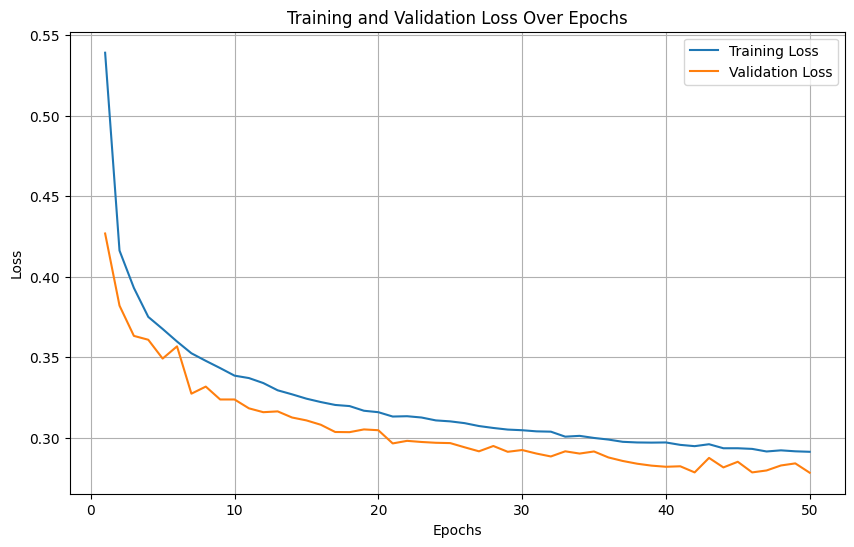

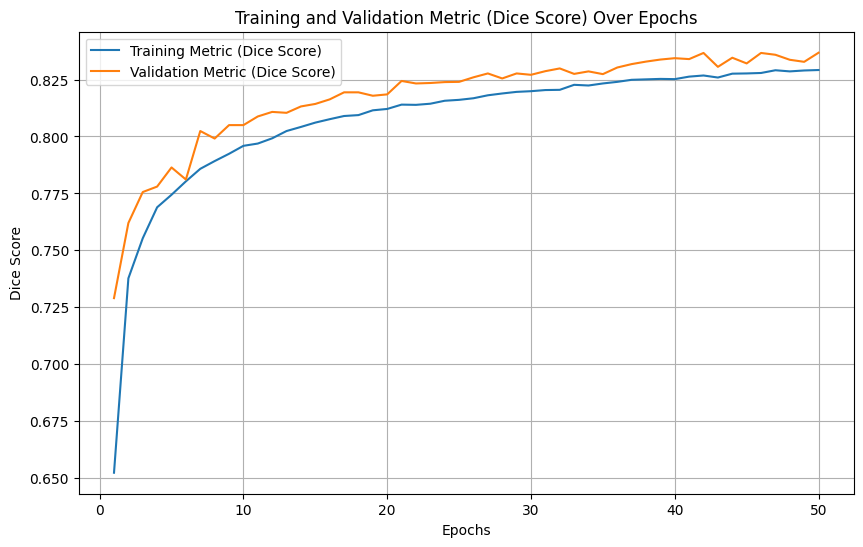

In [ ]:
# plot_loss_metric(training_loss,validation_loss,training_metric,validation_metric)
loss_filename, metric_filename = plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='unet_resnet50_freezed')

## Test

In [39]:
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}_b'
path =f'/content/drive/MyDrive/{folder}'

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
model_path = path + "/best_model.pth"
model = load_model_weights(model, model_path, device)

In [ ]:
n_cpu = 8
batch_size = 32
test_dataset = BuildingDataset("/content/test_images/test", "/content/test_masks/test", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [41]:
metrics = compute_metrics(model, test_dataloader, device)
print("Model Metrics:", metrics)

Evaluating:   0%|          | 0/259 [00:00<?, ?it/s]

Model Metrics: {'accuracy': 0.9656732109982995, 'iou': 0.8383749386352113}


In [42]:
visualize_predictions_and_explain(model, test_dataloader, num_images=50, device=device, seed =24, title = folder , save_path=path+'/explain/')

Output hidden; open in https://colab.research.google.com to view.

# Experiment 3

* Architecture: UNET
* Backbone: **resnext50_32x4d**
* pretrained: **None**
* Loss: Jaccardi
* Metric: DICE coef
* Epochs: 50
* Batch size: 32
* T/V/V: 0.7/0.15/0.15 seed=42
* Early stopping with patience: 10


## Train - Validate

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'None'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)

# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone, pretrained=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.6497, Training Metric: 0.5289
Validation Loss: 0.5551, Validation Metric: 0.6130
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.5307, Training Metric: 0.6384
Validation Loss: 0.4679, Validation Metric: 0.6911
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4882, Training Metric: 0.6762
Validation Loss: 0.4781, Validation Metric: 0.6811
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4764, Training Metric: 0.6864
Validation Loss: 0.4241, Validation Metric: 0.7279
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4568, Training Metric: 0.7031
Validation Loss: 0.4386, Validation Metric: 0.7147
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4473, Training Metric: 0.7108
Validation Loss: 0.4311, Validation Metric: 0.7210
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4404, Training Metric: 0.7166
Validation Loss: 0.3999, Validation Metric: 0.7473
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4302, Training Metric: 0.7251
Validation Loss: 0.4087, Validation Metric: 0.7399
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4223, Training Metric: 0.7314
Validation Loss: 0.3848, Validation Metric: 0.7589
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4155, Training Metric: 0.7369
Validation Loss: 0.3901, Validation Metric: 0.7546
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4141, Training Metric: 0.7378
Validation Loss: 0.4126, Validation Metric: 0.7371
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4057, Training Metric: 0.7447
Validation Loss: 0.3895, Validation Metric: 0.7557
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4044, Training Metric: 0.7456
Validation Loss: 0.4091, Validation Metric: 0.7390
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4008, Training Metric: 0.7485
Validation Loss: 0.3656, Validation Metric: 0.7734
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3941, Training Metric: 0.7538
Validation Loss: 0.3679, Validation Metric: 0.7718
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3868, Training Metric: 0.7594
Validation Loss: 0.3633, Validation Metric: 0.7753
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3848, Training Metric: 0.7609
Validation Loss: 0.3559, Validation Metric: 0.7806
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3826, Training Metric: 0.7626
Validation Loss: 0.3560, Validation Metric: 0.7805
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3803, Training Metric: 0.7644
Validation Loss: 0.3644, Validation Metric: 0.7741
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3821, Training Metric: 0.7629
Validation Loss: 0.3456, Validation Metric: 0.7885
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3751, Training Metric: 0.7684
Validation Loss: 0.3479, Validation Metric: 0.7867
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3720, Training Metric: 0.7707
Validation Loss: 0.3611, Validation Metric: 0.7767
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3703, Training Metric: 0.7721
Validation Loss: 0.3517, Validation Metric: 0.7839
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3686, Training Metric: 0.7733
Validation Loss: 0.3574, Validation Metric: 0.7792
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3628, Training Metric: 0.7777
Validation Loss: 0.3411, Validation Metric: 0.7917
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3646, Training Metric: 0.7763
Validation Loss: 0.3454, Validation Metric: 0.7883
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3638, Training Metric: 0.7769
Validation Loss: 0.3386, Validation Metric: 0.7937
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3621, Training Metric: 0.7782
Validation Loss: 0.3377, Validation Metric: 0.7942
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3596, Training Metric: 0.7800
Validation Loss: 0.3473, Validation Metric: 0.7871
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3604, Training Metric: 0.7794
Validation Loss: 0.3416, Validation Metric: 0.7916
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3553, Training Metric: 0.7831
Validation Loss: 0.3606, Validation Metric: 0.7767
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3567, Training Metric: 0.7821
Validation Loss: 0.3253, Validation Metric: 0.8030
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3548, Training Metric: 0.7835
Validation Loss: 0.3315, Validation Metric: 0.7988
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3501, Training Metric: 0.7871
Validation Loss: 0.3399, Validation Metric: 0.7925
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3493, Training Metric: 0.7877
Validation Loss: 0.4420, Validation Metric: 0.7096
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3499, Training Metric: 0.7872
Validation Loss: 0.3365, Validation Metric: 0.7950
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3510, Training Metric: 0.7863
Validation Loss: 0.3905, Validation Metric: 0.7537
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3603, Training Metric: 0.7794
Validation Loss: 0.3288, Validation Metric: 0.8008
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 6


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3439, Training Metric: 0.7916
Validation Loss: 0.3277, Validation Metric: 0.8015
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 7


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3399, Training Metric: 0.7946
Validation Loss: 0.3253, Validation Metric: 0.8032
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3396, Training Metric: 0.7949
Validation Loss: 0.3307, Validation Metric: 0.7989
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3386, Training Metric: 0.7955
Validation Loss: 0.3202, Validation Metric: 0.8066
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3372, Training Metric: 0.7966
Validation Loss: 0.3227, Validation Metric: 0.8050
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3354, Training Metric: 0.7979
Validation Loss: 0.3241, Validation Metric: 0.8043
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3371, Training Metric: 0.7967
Validation Loss: 0.3240, Validation Metric: 0.8043
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3362, Training Metric: 0.7972
Validation Loss: 0.3248, Validation Metric: 0.8035
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3363, Training Metric: 0.7972
Validation Loss: 0.3230, Validation Metric: 0.8050
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3330, Training Metric: 0.7996
Validation Loss: 0.3249, Validation Metric: 0.8030
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 6


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3326, Training Metric: 0.7998
Validation Loss: 0.3205, Validation Metric: 0.8069
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 7


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3352, Training Metric: 0.7979
Validation Loss: 0.3176, Validation Metric: 0.8084
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/best_model.pth
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_resnext50_32x4d_None/final_model.pth


In [ ]:
training_loss = [
    0.6497, 0.5307, 0.4882, 0.4764, 0.4568, 0.4473, 0.4404, 0.4302, 0.4223,
    0.4155, 0.4141, 0.4057, 0.4044, 0.4008, 0.3941, 0.3868, 0.3848, 0.3826,
    0.3803, 0.3821, 0.3751, 0.3720, 0.3703, 0.3686, 0.3628, 0.3646, 0.3638,
    0.3621, 0.3596, 0.3604, 0.3553, 0.3567, 0.3548, 0.3501, 0.3493, 0.3499,
    0.3510, 0.3603, 0.3439, 0.3399, 0.3396, 0.3386, 0.3372, 0.3354, 0.3371,
    0.3362, 0.3363, 0.3330, 0.3326, 0.3352
]
validation_loss = [
    0.5551, 0.4679, 0.4781, 0.4241, 0.4386, 0.4311, 0.3999, 0.4087, 0.3848,
    0.3901, 0.4126, 0.3895, 0.4091, 0.3656, 0.3679, 0.3633, 0.3559, 0.3560,
    0.3644, 0.3456, 0.3479, 0.3611, 0.3517, 0.3574, 0.3411, 0.3454, 0.3386,
    0.3377, 0.3473, 0.3416, 0.3606, 0.3253, 0.3315, 0.3399, 0.4420, 0.3365,
    0.3905, 0.3288, 0.3277, 0.3253, 0.3307, 0.3202, 0.3227, 0.3241, 0.3240,
    0.3248, 0.3230, 0.3249, 0.3205, 0.3176
]
training_metric = [
    0.5289, 0.6384, 0.6762, 0.6864, 0.7031, 0.7108, 0.7166, 0.7251, 0.7314,
    0.7369, 0.7378, 0.7447, 0.7456, 0.7485, 0.7538, 0.7594, 0.7609, 0.7626,
    0.7644, 0.7629, 0.7684, 0.7707, 0.7721, 0.7733, 0.7777, 0.7763, 0.7769,
    0.7782, 0.7800, 0.7794, 0.7831, 0.7821, 0.7835, 0.7871, 0.7877, 0.7872,
    0.7863, 0.7794, 0.7916, 0.7946, 0.7949, 0.7955, 0.7966, 0.7979, 0.7967,
    0.7972, 0.7972, 0.7996, 0.7998, 0.7979
]
validation_metric = [
    0.6130, 0.6911, 0.6811, 0.7279, 0.7147, 0.7210, 0.7473, 0.7399, 0.7589,
    0.7546, 0.7371, 0.7557, 0.7390, 0.7734, 0.7718, 0.7753, 0.7806, 0.7805,
    0.7741, 0.7885, 0.7867, 0.7767, 0.7839, 0.7792, 0.7917, 0.7883, 0.7937,
    0.7942, 0.7871, 0.7916, 0.7767, 0.8030, 0.7988, 0.7925, 0.7096, 0.7950,
    0.7537, 0.8008, 0.8015, 0.8032, 0.7989, 0.8066, 0.8050, 0.8043, 0.8043,
    0.8035, 0.8050, 0.8030, 0.8069, 0.8084
]

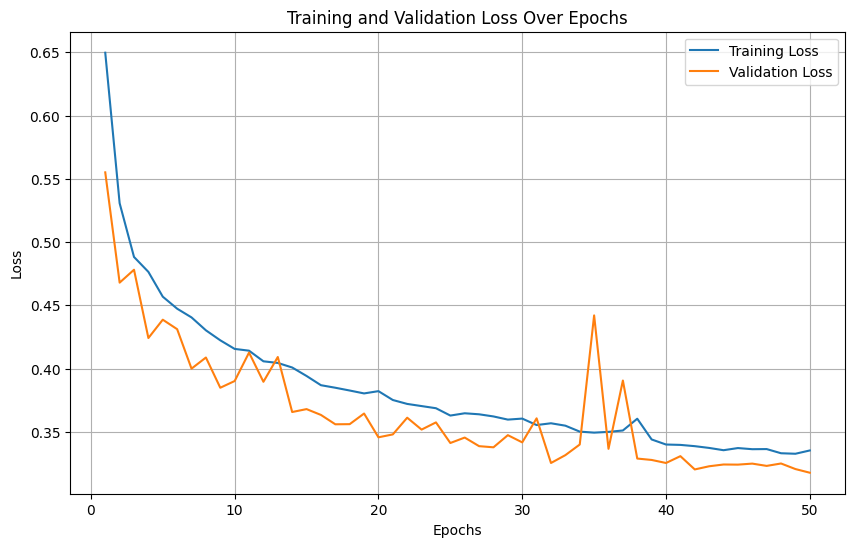

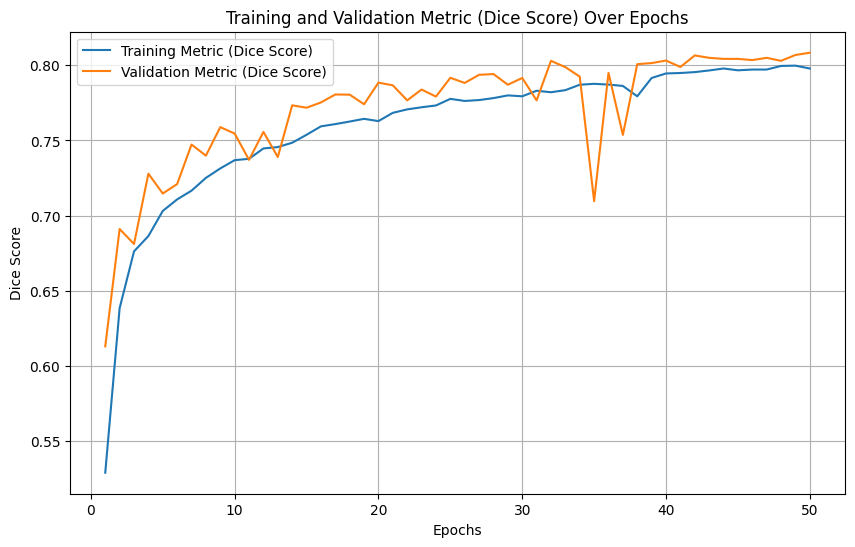

In [ ]:
# plot_loss_metric(training_loss,validation_loss,training_metric,validation_metric)
loss_filename, metric_filename = plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='unet_resnext50_32x4d_no_pretrained')

## Test

In [43]:
archi = 'unet'
backbone = 'resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'None'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
model_path = path + "/best_model.pth"
model = load_model_weights(model, model_path, device)

In [ ]:
n_cpu = 8
batch_size = 32
test_dataset = BuildingDataset("/content/test_images/test", "/content/test_masks/test", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [45]:
metrics = compute_metrics(model, test_dataloader, device)
print("Model Metrics:", metrics)

Evaluating:   0%|          | 0/259 [00:00<?, ?it/s]

Model Metrics: {'accuracy': 0.9603241806324845, 'iou': 0.8151434762262836}


In [46]:
visualize_predictions_and_explain(model, test_dataloader, num_images=50, device=device, seed =24, title = folder , save_path=path+'/explain/')

Output hidden; open in https://colab.research.google.com to view.

# Experiment 4

* Architecture: UNET
* Backbone: **resnet50**
* pretrained: **None**
* Loss: Jaccardi
* Metric: DICE coef
* Epochs: 50
* Batch size: 32
* T/V/V: 0.7/0.15/0.15 seed=42
* Early stopping with patience: 10


## Train - Validate

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'None'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)


# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone, pretrained=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.6678, Training Metric: 0.5110
Validation Loss: 0.5790, Validation Metric: 0.5874
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.5479, Training Metric: 0.6219
Validation Loss: 0.5015, Validation Metric: 0.6617
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.5068, Training Metric: 0.6597
Validation Loss: 0.4736, Validation Metric: 0.6849
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4827, Training Metric: 0.6809
Validation Loss: 0.4419, Validation Metric: 0.7126
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4660, Training Metric: 0.6953
Validation Loss: 0.4405, Validation Metric: 0.7141
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4574, Training Metric: 0.7024
Validation Loss: 0.4427, Validation Metric: 0.7122
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4463, Training Metric: 0.7117
Validation Loss: 0.4519, Validation Metric: 0.7041
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4384, Training Metric: 0.7183
Validation Loss: 0.4226, Validation Metric: 0.7286
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4301, Training Metric: 0.7250
Validation Loss: 0.4025, Validation Metric: 0.7445
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4260, Training Metric: 0.7284
Validation Loss: 0.4085, Validation Metric: 0.7399
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4365, Training Metric: 0.7196
Validation Loss: 0.4179, Validation Metric: 0.7319
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4240, Training Metric: 0.7299
Validation Loss: 0.3972, Validation Metric: 0.7491
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4181, Training Metric: 0.7347
Validation Loss: 0.3847, Validation Metric: 0.7587
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4083, Training Metric: 0.7426
Validation Loss: 0.3824, Validation Metric: 0.7606
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4069, Training Metric: 0.7435
Validation Loss: 0.3938, Validation Metric: 0.7516
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.4001, Training Metric: 0.7491
Validation Loss: 0.3846, Validation Metric: 0.7588
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3979, Training Metric: 0.7507
Validation Loss: 0.3806, Validation Metric: 0.7619
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3927, Training Metric: 0.7548
Validation Loss: 0.3712, Validation Metric: 0.7693
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3929, Training Metric: 0.7547
Validation Loss: 0.3712, Validation Metric: 0.7692
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3850, Training Metric: 0.7607
Validation Loss: 0.3639, Validation Metric: 0.7744
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3867, Training Metric: 0.7594
Validation Loss: 0.3531, Validation Metric: 0.7827
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3842, Training Metric: 0.7613
Validation Loss: 0.3649, Validation Metric: 0.7742
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3828, Training Metric: 0.7624
Validation Loss: 0.3579, Validation Metric: 0.7795
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3736, Training Metric: 0.7694
Validation Loss: 0.3537, Validation Metric: 0.7818
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3752, Training Metric: 0.7683
Validation Loss: 0.3570, Validation Metric: 0.7797
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3764, Training Metric: 0.7674
Validation Loss: 0.3539, Validation Metric: 0.7823
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3693, Training Metric: 0.7728
Validation Loss: 0.3508, Validation Metric: 0.7838
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

In [ ]:
# Load the checkpoint
checkpoint_path = '/content/drive/MyDrive/unet_resnet50_None/best_model.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Print the keys in the checkpoint
    print("Keys in the checkpoint:", checkpoint.keys())
else:
    print("Checkpoint file not found.")

Keys in the checkpoint: odict_keys(['encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.layer1.0.conv1.weight', 'encoder.layer1.0.bn1.weight', 'encoder.layer1.0.bn1.bias', 'encoder.layer1.0.bn1.running_mean', 'encoder.layer1.0.bn1.running_var', 'encoder.layer1.0.bn1.num_batches_tracked', 'encoder.layer1.0.conv2.weight', 'encoder.layer1.0.bn2.weight', 'encoder.layer1.0.bn2.bias', 'encoder.layer1.0.bn2.running_mean', 'encoder.layer1.0.bn2.running_var', 'encoder.layer1.0.bn2.num_batches_tracked', 'encoder.layer1.0.conv3.weight', 'encoder.layer1.0.bn3.weight', 'encoder.layer1.0.bn3.bias', 'encoder.layer1.0.bn3.running_mean', 'encoder.layer1.0.bn3.running_var', 'encoder.layer1.0.bn3.num_batches_tracked', 'encoder.layer1.0.downsample.0.weight', 'encoder.layer1.0.downsample.1.weight', 'encoder.layer1.0.downsample.1.bias', 'encoder.layer1.0.downsample.1.running_mean', 'encoder.layer

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'None'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)

# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone, pretrained=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps


# Load the checkpoint
checkpoint_path = '/content/drive/MyDrive/unet_resnet50_None/best_model.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model state directly
    model.load_state_dict(checkpoint)
    print("Model state loaded successfully.")
else:
    print("Checkpoint file not found.")

start_epoch = 27
for epoch in range(start_epoch, num_epochs + 1):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('Patience for early stopping:', patience)
    print('Epochs with no improvement in the validation loss:', epochs_no_improve)

    avg_train_loss, avg_train_metric = train_one_epoch(model, train_dataloader, optimizer, device, accumulation_steps)
    scheduler.step(avg_train_loss)
    avg_val_loss, avg_val_metric = validate_one_epoch(model, valid_dataloader, device)

    # Logging training and validation metrics
    # writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    # writer.add_scalar('Metric/Train', avg_train_metric, epoch)
    # writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    # writer.add_scalar('Metric/Validation', avg_val_metric, epoch)

    print(f"Training Loss: {avg_train_loss:.4f}, Training Metric: {avg_train_metric:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Metric: {avg_val_metric:.4f}")

    # # Save model every 'save_interval' epochs
    # if (epoch + 1) % save_interval == 0:
    #     save_path = f'/content/drive/MyDrive/{folder}/{model_name}_epoch_{epoch+1}.pth'
    #     save_model(model, save_path)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_model(model, f'/content/drive/MyDrive/{folder}/best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            early_stop = True
            break

if not early_stop:
    print("Completed all epochs without early stopping.")

# Save the final model
save_model(model, f'/content/drive/MyDrive/{folder}/final_model.pth')
# writer.close()

Model state loaded successfully.
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3717, Training Metric: 0.7709
Validation Loss: 0.3530, Validation Metric: 0.7825
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3693, Training Metric: 0.7728
Validation Loss: 0.3558, Validation Metric: 0.7804
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3678, Training Metric: 0.7738
Validation Loss: 0.3759, Validation Metric: 0.7649
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3643, Training Metric: 0.7765
Validation Loss: 0.3540, Validation Metric: 0.7819
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3669, Training Metric: 0.7745
Validation Loss: 0.3399, Validation Metric: 0.7925
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3607, Training Metric: 0.7792
Validation Loss: 0.3466, Validation Metric: 0.7875
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3581, Training Metric: 0.7810
Validation Loss: 0.3374, Validation Metric: 0.7945
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3634, Training Metric: 0.7771
Validation Loss: 0.3333, Validation Metric: 0.7975
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3609, Training Metric: 0.7790
Validation Loss: 0.3555, Validation Metric: 0.7809
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3590, Training Metric: 0.7805
Validation Loss: 0.3331, Validation Metric: 0.7974
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3526, Training Metric: 0.7852
Validation Loss: 0.3425, Validation Metric: 0.7906
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3493, Training Metric: 0.7877
Validation Loss: 0.3351, Validation Metric: 0.7961
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

In [ ]:
# Setup
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'None'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)

# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone, pretrained=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps


# Load the checkpoint
checkpoint_path = '/content/drive/MyDrive/unet_resnet50_None/best_model.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model state directly
    model.load_state_dict(checkpoint)
    print("Model state loaded successfully.")
else:
    print("Checkpoint file not found.")

start_epoch = 39
for epoch in range(start_epoch, num_epochs + 1):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('Patience for early stopping:', patience)
    print('Epochs with no improvement in the validation loss:', epochs_no_improve)

    avg_train_loss, avg_train_metric = train_one_epoch(model, train_dataloader, optimizer, device, accumulation_steps)
    scheduler.step(avg_train_loss)
    avg_val_loss, avg_val_metric = validate_one_epoch(model, valid_dataloader, device)

    # Logging training and validation metrics
    # writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    # writer.add_scalar('Metric/Train', avg_train_metric, epoch)
    # writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    # writer.add_scalar('Metric/Validation', avg_val_metric, epoch)

    print(f"Training Loss: {avg_train_loss:.4f}, Training Metric: {avg_train_metric:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Metric: {avg_val_metric:.4f}")

    # # Save model every 'save_interval' epochs
    # if (epoch + 1) % save_interval == 0:
    #     save_path = f'/content/drive/MyDrive/{folder}/{model_name}_epoch_{epoch+1}.pth'
    #     save_model(model, save_path)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_model(model, f'/content/drive/MyDrive/{folder}/best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            early_stop = True
            break

if not early_stop:
    print("Completed all epochs without early stopping.")

# Save the final model
save_model(model, f'/content/drive/MyDrive/{folder}/final_model.pth')
# writer.close()

Model state loaded successfully.
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3538, Training Metric: 0.7843
Validation Loss: 0.3409, Validation Metric: 0.7916
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3521, Training Metric: 0.7856
Validation Loss: 0.3339, Validation Metric: 0.7968
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3552, Training Metric: 0.7833
Validation Loss: 0.3450, Validation Metric: 0.7887
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3515, Training Metric: 0.7860
Validation Loss: 0.3360, Validation Metric: 0.7954
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3498, Training Metric: 0.7873
Validation Loss: 0.3333, Validation Metric: 0.7973
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3484, Training Metric: 0.7884
Validation Loss: 0.3328, Validation Metric: 0.7981
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3467, Training Metric: 0.7894
Validation Loss: 0.3511, Validation Metric: 0.7841
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3483, Training Metric: 0.7884
Validation Loss: 0.3360, Validation Metric: 0.7955
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3463, Training Metric: 0.7898
Validation Loss: 0.3725, Validation Metric: 0.7672
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3538, Training Metric: 0.7842
Validation Loss: 0.3347, Validation Metric: 0.7964
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3422, Training Metric: 0.7929
Validation Loss: 0.3255, Validation Metric: 0.8032
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Epoch 51/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.3406, Training Metric: 0.7940
Validation Loss: 0.3173, Validation Metric: 0.8091
Model saved to /content/drive/MyDrive/unet_resnet50_None/best_model.pth
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_resnet50_None/final_model.pth


In [ ]:
training_loss = [
    0.6678, 0.5479, 0.5068, 0.4827, 0.4660, 0.4574, 0.4463, 0.4384, 0.4301, 0.4260,
    0.4365, 0.4240, 0.4181, 0.4083, 0.4069, 0.4001, 0.3979, 0.3927, 0.3929, 0.3850,
    0.3867, 0.3842, 0.3828, 0.3736, 0.3752, 0.3764, 0.3693, 0.3717, 0.3693, 0.3678,
    0.3643, 0.3669, 0.3607, 0.3581, 0.3634, 0.3609, 0.3590, 0.3526, 0.3493, 0.3538,
    0.3521, 0.3552, 0.3515, 0.3498, 0.3484, 0.3467, 0.3483, 0.3463, 0.3538, 0.3422
]
validation_loss = [
    0.5790, 0.5015, 0.4736, 0.4419, 0.4405, 0.4427, 0.4519, 0.4226, 0.4025, 0.4085,
    0.4179, 0.3972, 0.3847, 0.3824, 0.3938, 0.3846, 0.3806, 0.3712, 0.3712, 0.3639,
    0.3531, 0.3649, 0.3579, 0.3537, 0.3570, 0.3539, 0.3508, 0.3530, 0.3558, 0.3759,
    0.3540, 0.3399, 0.3466, 0.3374, 0.3333, 0.3555, 0.3331, 0.3425, 0.3351, 0.3409,
    0.3339, 0.3450, 0.3360, 0.3333, 0.3328, 0.3511, 0.3360, 0.3725, 0.3347, 0.3255
]
training_metric = [
    0.5110, 0.6219, 0.6597, 0.6809, 0.6953, 0.7024, 0.7117, 0.7183, 0.7250, 0.7284,
    0.7196, 0.7299, 0.7347, 0.7426, 0.7435, 0.7491, 0.7507, 0.7548, 0.7547, 0.7607,
    0.7594, 0.7613, 0.7624, 0.7694, 0.7683, 0.7674, 0.7728, 0.7709, 0.7728, 0.7738,
    0.7765, 0.7745, 0.7792, 0.7810, 0.7771, 0.7790, 0.7805, 0.7852, 0.7877, 0.7843,
    0.7856, 0.7833, 0.7860, 0.7873, 0.7884, 0.7894, 0.7884, 0.7898, 0.7842, 0.7929
]
validation_metric = [
    0.5874, 0.6617, 0.6849, 0.7126, 0.7141, 0.7122, 0.7041, 0.7286, 0.7445, 0.7399,
    0.7319, 0.7491, 0.7587, 0.7606, 0.7516, 0.7588, 0.7619, 0.7693, 0.7692, 0.7744,
    0.7827, 0.7742, 0.7795, 0.7818, 0.7797, 0.7823, 0.7838, 0.7825, 0.7804, 0.7649,
    0.7819, 0.7925, 0.7875, 0.7945, 0.7975, 0.7809, 0.7974, 0.7906, 0.7961, 0.7916,
    0.7968, 0.7887, 0.7954, 0.7973, 0.7981, 0.7841, 0.7955, 0.7672, 0.7964, 0.8032
]

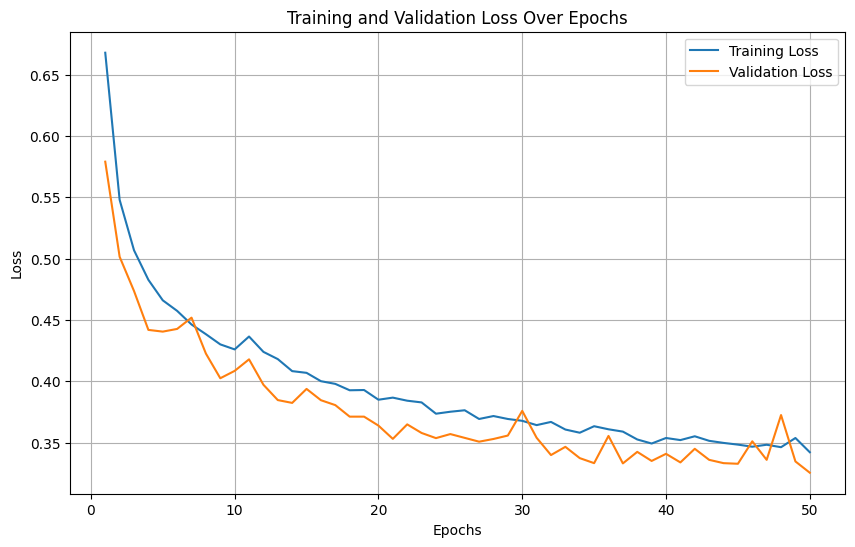

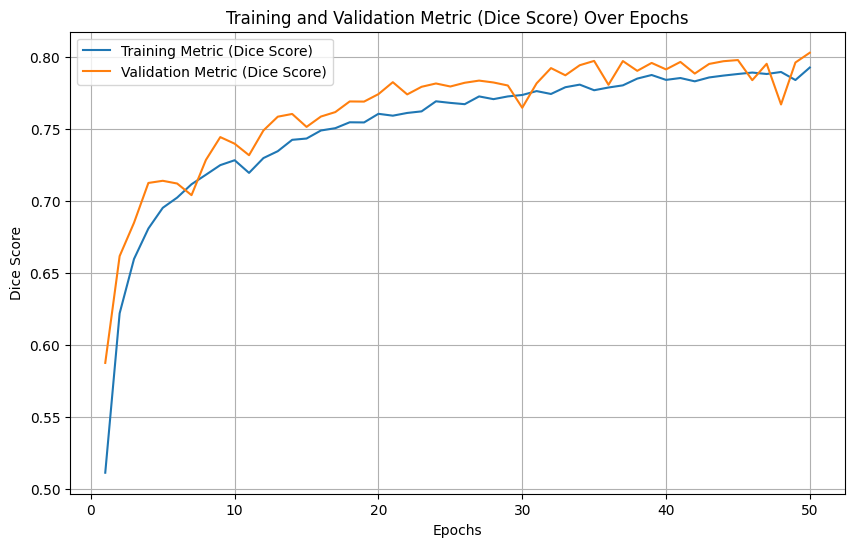

In [ ]:
# plot_loss_metric(training_loss,validation_loss,training_metric,validation_metric)
loss_filename, metric_filename = plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='unet_resnet50_no_pretrained')

## Test

In [47]:
archi = 'unet'
backbone = 'resnet50'
model_name=archi+'_'+backbone
pretrained = 'None'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
model_path = path + "/best_model.pth"
model = load_model_weights(model, model_path, device)

In [ ]:
n_cpu = 8
batch_size = 32
test_dataset = BuildingDataset("/content/test_images/test", "/content/test_masks/test", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [49]:
metrics = compute_metrics(model, test_dataloader, device)
print("Model Metrics:", metrics)

Evaluating:   0%|          | 0/259 [00:00<?, ?it/s]

Model Metrics: {'accuracy': 0.9601953830498066, 'iou': 0.8158185822326844}


In [50]:
visualize_predictions_and_explain(model, test_dataloader, num_images=50, device=device, seed =24, title = folder , save_path=path+'/explain/')

Output hidden; open in https://colab.research.google.com to view.

# Experiment 5

* Architecture: UNET
* Backbone: **se_resnext50**
* pretrained: **Imagenet**
* Freezed encoder's weights
* Loss: Jaccardi
* Metric: DICE coef
* Epochs: 50
* Batch size: 32
* T/V/V: 0.7/0.15/0.15 seed=42
* Early stopping with patience: 10

## Train - Validate

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Setup
archi = 'unet'
backbone = 'se_resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'
os.makedirs(path, exist_ok=True)

# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

# Training parameters
num_epochs = 50
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:10<00:00, 356kB/s]


In [ ]:
# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

```
Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:40<00:00, 4.40it/s]
Validation: 100%
259/259 [01:06<00:00, 4.65it/s]
Training Loss: 0.4627, Training Metric: 0.7156
Validation Loss: 0.4002, Validation Metric: 0.7499
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.75it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.3699, Training Metric: 0.7737
Validation Loss: 0.3451, Validation Metric: 0.7903
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.76it/s]
Validation: 100%
259/259 [01:06<00:00, 3.90it/s]
Training Loss: 0.3516, Training Metric: 0.7868
Validation Loss: 0.3273, Validation Metric: 0.8028
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.75it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.3413, Training Metric: 0.7941
Validation Loss: 0.3160, Validation Metric: 0.8106
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.74it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.3345, Training Metric: 0.7989
Validation Loss: 0.3105, Validation Metric: 0.8145
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.74it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.3288, Training Metric: 0.8030
Validation Loss: 0.3102, Validation Metric: 0.8148
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.3239, Training Metric: 0.8064
Validation Loss: 0.3038, Validation Metric: 0.8192
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.3193, Training Metric: 0.8097
Validation Loss: 0.3029, Validation Metric: 0.8197
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.75it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.3153, Training Metric: 0.8125
Validation Loss: 0.3041, Validation Metric: 0.8189
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:34<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.3120, Training Metric: 0.8149
Validation Loss: 0.2953, Validation Metric: 0.8252
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.3108, Training Metric: 0.8156
Validation Loss: 0.2972, Validation Metric: 0.8239
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:35<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.3077, Training Metric: 0.8179
Validation Loss: 0.2981, Validation Metric: 0.8232
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2
Training: 100%
1205/1205 [04:35<00:00, 4.71it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.3050, Training Metric: 0.8198
Validation Loss: 0.2955, Validation Metric: 0.8250
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3
Training: 100%
1205/1205 [04:36<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.3023, Training Metric: 0.8216
Validation Loss: 0.2905, Validation Metric: 0.8283
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:34<00:00, 4.74it/s]
Validation: 100%
259/259 [01:06<00:00, 3.95it/s]
Training Loss: 0.3013, Training Metric: 0.8222
Validation Loss: 0.2876, Validation Metric: 0.8305
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.3008, Training Metric: 0.8226
Validation Loss: 0.2853, Validation Metric: 0.8320
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:34<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.95it/s]
Training Loss: 0.2972, Training Metric: 0.8251
Validation Loss: 0.2846, Validation Metric: 0.8325
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:37<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2944, Training Metric: 0.8271
Validation Loss: 0.2865, Validation Metric: 0.8313
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:34<00:00, 4.75it/s]
Validation: 100%
259/259 [01:06<00:00, 3.90it/s]
Training Loss: 0.2928, Training Metric: 0.8282
Validation Loss: 0.2835, Validation Metric: 0.8333
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.2928, Training Metric: 0.8281
Validation Loss: 0.2829, Validation Metric: 0.8338
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:34<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.91it/s]
Training Loss: 0.2912, Training Metric: 0.8293
Validation Loss: 0.2814, Validation Metric: 0.8347
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.70it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2890, Training Metric: 0.8308
Validation Loss: 0.2779, Validation Metric: 0.8371
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2892, Training Metric: 0.8306
Validation Loss: 0.2800, Validation Metric: 0.8354
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:36<00:00, 4.74it/s]
Validation: 100%
259/259 [01:06<00:00, 3.90it/s]
Training Loss: 0.2888, Training Metric: 0.8309
Validation Loss: 0.2802, Validation Metric: 0.8356
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2
Training: 100%
1205/1205 [04:37<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2873, Training Metric: 0.8319
Validation Loss: 0.2768, Validation Metric: 0.8379
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:37<00:00, 4.76it/s]
Validation: 100%
259/259 [01:06<00:00, 3.91it/s]
Training Loss: 0.2860, Training Metric: 0.8328
Validation Loss: 0.2762, Validation Metric: 0.8382
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:39<00:00, 4.69it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2849, Training Metric: 0.8336
Validation Loss: 0.2794, Validation Metric: 0.8359
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:41<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2848, Training Metric: 0.8337
Validation Loss: 0.2798, Validation Metric: 0.8356
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2
Training: 100%
1205/1205 [04:37<00:00, 4.75it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2839, Training Metric: 0.8343
Validation Loss: 0.2730, Validation Metric: 0.8404
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:35<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.95it/s]
Training Loss: 0.2812, Training Metric: 0.8361
Validation Loss: 0.2742, Validation Metric: 0.8396
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:37<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.96it/s]
Training Loss: 0.2815, Training Metric: 0.8359
Validation Loss: 0.2759, Validation Metric: 0.8385
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2
Training: 100%
1205/1205 [04:38<00:00, 4.75it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2810, Training Metric: 0.8363
Validation Loss: 0.2712, Validation Metric: 0.8416
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2796, Training Metric: 0.8371
Validation Loss: 0.2714, Validation Metric: 0.8415
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:37<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.2797, Training Metric: 0.8371
Validation Loss: 0.2710, Validation Metric: 0.8416
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:39<00:00, 4.71it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2784, Training Metric: 0.8380
Validation Loss: 0.2686, Validation Metric: 0.8433
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.95it/s]
Training Loss: 0.2787, Training Metric: 0.8378
Validation Loss: 0.2716, Validation Metric: 0.8413
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:38<00:00, 4.71it/s]
Validation: 100%
259/259 [01:06<00:00, 3.91it/s]
Training Loss: 0.2775, Training Metric: 0.8385
Validation Loss: 0.2699, Validation Metric: 0.8423
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2
Training: 100%
1205/1205 [04:40<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2773, Training Metric: 0.8387
Validation Loss: 0.2735, Validation Metric: 0.8400
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3
Training: 100%
1205/1205 [04:36<00:00, 4.75it/s]
Validation: 100%
259/259 [01:06<00:00, 3.95it/s]
Training Loss: 0.2760, Training Metric: 0.8396
Validation Loss: 0.2693, Validation Metric: 0.8429
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4
Training: 100%
1205/1205 [04:37<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2740, Training Metric: 0.8409
Validation Loss: 0.2667, Validation Metric: 0.8446
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:39<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2749, Training Metric: 0.8404
Validation Loss: 0.2687, Validation Metric: 0.8433
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:38<00:00, 4.71it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2741, Training Metric: 0.8409
Validation Loss: 0.2665, Validation Metric: 0.8448
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:38<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2753, Training Metric: 0.8400
Validation Loss: 0.2715, Validation Metric: 0.8413
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:37<00:00, 4.73it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2728, Training Metric: 0.8417
Validation Loss: 0.2667, Validation Metric: 0.8446
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2
Training: 100%
1205/1205 [04:37<00:00, 4.74it/s]
Validation: 100%
259/259 [01:06<00:00, 3.94it/s]
Training Loss: 0.2732, Training Metric: 0.8415
Validation Loss: 0.2662, Validation Metric: 0.8449
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.71it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2711, Training Metric: 0.8429
Validation Loss: 0.2662, Validation Metric: 0.8448
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:38<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.91it/s]
Training Loss: 0.2716, Training Metric: 0.8426
Validation Loss: 0.2674, Validation Metric: 0.8442
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1
Training: 100%
1205/1205 [04:37<00:00, 4.70it/s]
Validation: 100%
259/259 [01:06<00:00, 3.92it/s]
Training Loss: 0.2718, Training Metric: 0.8424
Validation Loss: 0.2662, Validation Metric: 0.8448
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2
Training: 100%
1205/1205 [04:39<00:00, 4.72it/s]
Validation: 100%
259/259 [01:06<00:00, 3.90it/s]
Training Loss: 0.2705, Training Metric: 0.8433
Validation Loss: 0.2615, Validation Metric: 0.8480
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0
Training: 100%
1205/1205 [04:36<00:00, 4.71it/s]
Validation: 100%
259/259 [01:06<00:00, 3.93it/s]
Training Loss: 0.2704, Training Metric: 0.8434
Validation Loss: 0.2646, Validation Metric: 0.8461
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/final_model.pth
```



In [ ]:
training_loss = [    0.4627, 0.3699, 0.3516, 0.3413, 0.3345, 0.3288, 0.3239, 0.3193,    0.3153, 0.3120, 0.3108, 0.3077, 0.3050, 0.3023, 0.3013, 0.3008,    0.2972, 0.2944, 0.2928, 0.2928, 0.2912, 0.2890, 0.2892, 0.2888,    0.2873, 0.2860, 0.2849, 0.2848, 0.2839, 0.2812, 0.2815, 0.2810,    0.2796, 0.2797, 0.2784, 0.2787, 0.2775, 0.2773, 0.2760, 0.2740,    0.2749, 0.2741, 0.2753, 0.2728, 0.2732, 0.2711, 0.2716, 0.2718,    0.2705, 0.2704]
validation_loss = [    0.4002, 0.3451, 0.3273, 0.3160, 0.3105, 0.3102, 0.3038, 0.3029,    0.3041, 0.2953, 0.2972, 0.2981, 0.2955, 0.2905, 0.2876, 0.2853,    0.2846, 0.2865, 0.2835, 0.2829, 0.2814, 0.2779, 0.2800, 0.2802,    0.2768, 0.2762, 0.2794, 0.2798, 0.2730, 0.2742, 0.2759, 0.2712,    0.2714, 0.2710, 0.2686, 0.2716, 0.2699, 0.2735, 0.2693, 0.2667,    0.2687, 0.2665, 0.2715, 0.2667, 0.2662, 0.2662, 0.2674, 0.2662,    0.2615, 0.2646]
training_metric = [    0.7156, 0.7737, 0.7868, 0.7941, 0.7989, 0.8030, 0.8064, 0.8097,    0.8125, 0.8149, 0.8156, 0.8179, 0.8198, 0.8216, 0.8222, 0.8226,    0.8251, 0.8271, 0.8282, 0.8281, 0.8293, 0.8308, 0.8306, 0.8309,    0.8319, 0.8328, 0.8336, 0.8337, 0.8343, 0.8361, 0.8359, 0.8363,    0.8371, 0.8371, 0.8380, 0.8378, 0.8385, 0.8387, 0.8396, 0.8409,    0.8404, 0.8409, 0.8400, 0.8417, 0.8415, 0.8429, 0.8426, 0.8424,    0.8433, 0.8434]
validation_metric = [    0.7499, 0.7903, 0.8028, 0.8106, 0.8145, 0.8148, 0.8192, 0.8197,    0.8189, 0.8252, 0.8239, 0.8232, 0.8250, 0.8283, 0.8305, 0.8320,    0.8325, 0.8313, 0.8333, 0.8338, 0.8347, 0.8371, 0.8354, 0.8356,    0.8379, 0.8382, 0.8359, 0.8356, 0.8404, 0.8396, 0.8385, 0.8416,    0.8415, 0.8416, 0.8433, 0.8413, 0.8423, 0.8400, 0.8429, 0.8446,    0.8433, 0.8448, 0.8413, 0.8446, 0.8449, 0.8448, 0.8442, 0.8448,    0.8480, 0.8461]

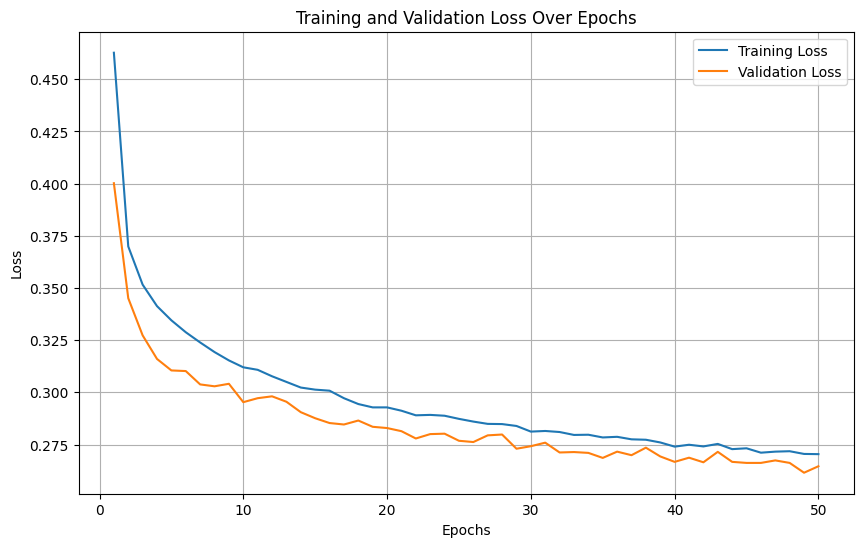

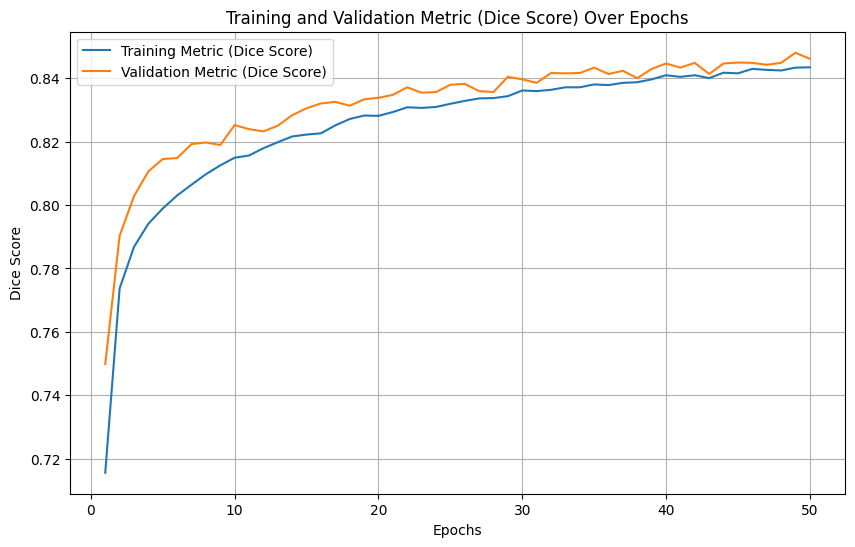

In [ ]:
# plot_loss_metric(training_loss,validation_loss,training_metric,validation_metric)
loss_filename, metric_filename = plot_loss_metric(training_loss, validation_loss, training_metric, validation_metric, epochs=50, model_name='unet_se_resnext50_32x4d_freezed')

## Test

In [51]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [52]:
archi = 'unet'
backbone = 'se_resnext50_32x4d'
model_name=archi+'_'+backbone
pretrained = 'imagenet'
folder = f'{archi}_{backbone}_{pretrained}'
path =f'/content/drive/MyDrive/{folder}'

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
model_path = path + "/best_model.pth"
model = load_model_weights(model, model_path, device)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:10<00:00, 356kB/s]


In [ ]:
n_cpu = 8
batch_size = 32
test_dataset = BuildingDataset("/content/test_images/test", "/content/test_masks/test", transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [54]:
metrics = compute_metrics(model, test_dataloader, device)
print("Model Metrics:", metrics)

Evaluating:   0%|          | 0/259 [00:00<?, ?it/s]

Model Metrics: {'accuracy': 0.9681814885967946, 'iou': 0.8470017535969806}


In [55]:
visualize_predictions_and_explain(model, test_dataloader, num_images=50, device=device, seed =24, title = folder , save_path=path+'/explain/')

Output hidden; open in https://colab.research.google.com to view.

## Try 50 more epochs

In [ ]:
# Load the checkpoint
checkpoint_path = f'{path}/best_model.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model state directly
    model.load_state_dict(checkpoint)
    print("Model state loaded successfully.")
else:
    print("Checkpoint file not found.")

for param in model.encoder.parameters():
    param.requires_grad = False

# RUN
train_and_validate_model(model,
                         train_dataloader,
                         valid_dataloader,
                         optimizer,
                         scheduler,
                         device,
                         num_epochs,
                         accumulation_steps,
                         patience,
                         folder,
                         model_name,
                         save_interval)

Model state loaded successfully.
Epoch 1/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2706, Training Metric: 0.8432
Validation Loss: 0.2641, Validation Metric: 0.8464
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 2/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Training Loss: 0.2694, Training Metric: 0.8440
Validation Loss: 0.2648, Validation Metric: 0.8460
Epoch 3/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2697, Training Metric: 0.8438
Validation Loss: 0.2626, Validation Metric: 0.8475
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 4/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2695, Training Metric: 0.8439
Validation Loss: 0.2664, Validation Metric: 0.8450
Epoch 5/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2691, Training Metric: 0.8443
Validation Loss: 0.2630, Validation Metric: 0.8471
Epoch 6/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2676, Training Metric: 0.8452
Validation Loss: 0.2637, Validation Metric: 0.8467
Epoch 7/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2678, Training Metric: 0.8451
Validation Loss: 0.2629, Validation Metric: 0.8471
Epoch 8/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2683, Training Metric: 0.8448
Validation Loss: 0.2618, Validation Metric: 0.8479
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 9/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2680, Training Metric: 0.8449
Validation Loss: 0.2639, Validation Metric: 0.8464
Epoch 10/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2673, Training Metric: 0.8454
Validation Loss: 0.2634, Validation Metric: 0.8469
Epoch 11/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2658, Training Metric: 0.8464
Validation Loss: 0.2615, Validation Metric: 0.8481
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 12/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2658, Training Metric: 0.8464
Validation Loss: 0.2624, Validation Metric: 0.8474
Epoch 13/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2664, Training Metric: 0.8460
Validation Loss: 0.2617, Validation Metric: 0.8480
Epoch 14/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2655, Training Metric: 0.8466
Validation Loss: 0.2593, Validation Metric: 0.8496
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 15/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2655, Training Metric: 0.8466
Validation Loss: 0.2625, Validation Metric: 0.8475
Epoch 16/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2648, Training Metric: 0.8471
Validation Loss: 0.2605, Validation Metric: 0.8488
Epoch 17/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2662, Training Metric: 0.8461
Validation Loss: 0.2613, Validation Metric: 0.8482
Epoch 18/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2639, Training Metric: 0.8477
Validation Loss: 0.2593, Validation Metric: 0.8496
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 19/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2640, Training Metric: 0.8476
Validation Loss: 0.2578, Validation Metric: 0.8506
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 20/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2630, Training Metric: 0.8483
Validation Loss: 0.2588, Validation Metric: 0.8499
Epoch 21/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2634, Training Metric: 0.8480
Validation Loss: 0.2632, Validation Metric: 0.8471
Epoch 22/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2624, Training Metric: 0.8487
Validation Loss: 0.2583, Validation Metric: 0.8503
Epoch 23/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2621, Training Metric: 0.8488
Validation Loss: 0.2599, Validation Metric: 0.8491
Epoch 24/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2622, Training Metric: 0.8488
Validation Loss: 0.2584, Validation Metric: 0.8502
Epoch 25/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2618, Training Metric: 0.8491
Validation Loss: 0.2577, Validation Metric: 0.8506
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 26/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2611, Training Metric: 0.8495
Validation Loss: 0.2610, Validation Metric: 0.8483
Epoch 27/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2626, Training Metric: 0.8486
Validation Loss: 0.2581, Validation Metric: 0.8504
Epoch 28/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2604, Training Metric: 0.8500
Validation Loss: 0.2568, Validation Metric: 0.8512
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 29/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2618, Training Metric: 0.8491
Validation Loss: 0.2575, Validation Metric: 0.8508
Epoch 30/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2600, Training Metric: 0.8503
Validation Loss: 0.2615, Validation Metric: 0.8481
Epoch 31/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2606, Training Metric: 0.8498
Validation Loss: 0.2580, Validation Metric: 0.8504
Epoch 32/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2597, Training Metric: 0.8505
Validation Loss: 0.2568, Validation Metric: 0.8512
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 33/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2584, Training Metric: 0.8513
Validation Loss: 0.2546, Validation Metric: 0.8527
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 34/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2594, Training Metric: 0.8506
Validation Loss: 0.2546, Validation Metric: 0.8527
Epoch 35/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2587, Training Metric: 0.8511
Validation Loss: 0.2543, Validation Metric: 0.8528
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 36/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2588, Training Metric: 0.8510
Validation Loss: 0.2565, Validation Metric: 0.8514
Epoch 37/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2579, Training Metric: 0.8516
Validation Loss: 0.2596, Validation Metric: 0.8493
Epoch 38/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2584, Training Metric: 0.8513
Validation Loss: 0.2559, Validation Metric: 0.8518
Epoch 39/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2580, Training Metric: 0.8515
Validation Loss: 0.2540, Validation Metric: 0.8531
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 40/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2577, Training Metric: 0.8518
Validation Loss: 0.2544, Validation Metric: 0.8528
Epoch 41/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2589, Training Metric: 0.8510
Validation Loss: 0.2536, Validation Metric: 0.8533
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 42/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2566, Training Metric: 0.8525
Validation Loss: 0.2540, Validation Metric: 0.8531
Epoch 43/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2575, Training Metric: 0.8519
Validation Loss: 0.2557, Validation Metric: 0.8520
Epoch 44/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2563, Training Metric: 0.8528
Validation Loss: 0.2529, Validation Metric: 0.8539
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/best_model.pth
Epoch 45/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 0


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2559, Training Metric: 0.8530
Validation Loss: 0.2551, Validation Metric: 0.8524
Epoch 46/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 1


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2556, Training Metric: 0.8532
Validation Loss: 0.2567, Validation Metric: 0.8513
Epoch 47/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 2


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2569, Training Metric: 0.8523
Validation Loss: 0.2540, Validation Metric: 0.8531
Epoch 48/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 3


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2559, Training Metric: 0.8529
Validation Loss: 0.2550, Validation Metric: 0.8523
Epoch 49/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 4


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2561, Training Metric: 0.8529
Validation Loss: 0.2540, Validation Metric: 0.8532
Epoch 50/50
Patience for early stopping: 10
Epochs with no improvement in the validation loss: 5


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Validation:   0%|          | 0/259 [00:00<?, ?it/s]

Training Loss: 0.2545, Training Metric: 0.8539
Validation Loss: 0.2548, Validation Metric: 0.8526
Completed all epochs without early stopping.
Model saved to /content/drive/MyDrive/unet_se_resnext50_32x4d_imagenet/final_model.pth


In [ ]:
training_loss = [
     0.2706, 0.2694, 0.2697, 0.2695, 0.2691, 0.2676, 0.2678, 0.2683, 0.2680, 0.2673,
    0.2658, 0.2658, 0.2664, 0.2655, 0.2655, 0.2648, 0.2662, 0.2639, 0.2640, 0.2630,
    0.2634, 0.2624, 0.2621, 0.2622, 0.2618, 0.2611, 0.2626, 0.2604, 0.2618, 0.2600,
    0.2606, 0.2597, 0.2584, 0.2594, 0.2587, 0.2588, 0.2579, 0.2584, 0.2580, 0.2577,
    0.2589, 0.2566, 0.2575, 0.2563, 0.2559, 0.2556, 0.2569, 0.2559, 0.2561, 0.2545
]

validation_loss = [
    0.2641, 0.2648, 0.2626, 0.2664, 0.2630, 0.2637, 0.2629, 0.2618, 0.2639, 0.2634,
    0.2615, 0.2624, 0.2617, 0.2593, 0.2625, 0.2605, 0.2613, 0.2593, 0.2578, 0.2588,
    0.2632, 0.2583, 0.2599, 0.2584, 0.2577, 0.2610, 0.2581, 0.2568, 0.2575, 0.2615,
    0.2580, 0.2568, 0.2546, 0.2546, 0.2543, 0.2565, 0.2596, 0.2559, 0.2540, 0.2544,
    0.2536, 0.2540, 0.2557, 0.2529, 0.2551, 0.2567, 0.2540, 0.2550, 0.2540, 0.2548
]
training_metric = [
    0.8432, 0.8440, 0.8438, 0.8439, 0.8443, 0.8452, 0.8451, 0.8448, 0.8449, 0.8454,
    0.8464, 0.8464, 0.8460, 0.8466, 0.8466, 0.8471, 0.8461, 0.8477, 0.8476, 0.8483,
    0.8480, 0.8487, 0.8488, 0.8488, 0.8491, 0.8495, 0.8486, 0.8500, 0.8491, 0.8503,
    0.8498, 0.8505, 0.8513, 0.8506, 0.8511, 0.8510, 0.8516, 0.8513, 0.8515, 0.8518,
    0.8510, 0.8525, 0.8519, 0.8528, 0.8530, 0.8532, 0.8523, 0.8529, 0.8529, 0.8539
]

validation_metric = [
    0.8464, 0.8460, 0.8475, 0.8450, 0.8471, 0.8467, 0.8471, 0.8479, 0.8464, 0.8469,
    0.8481, 0.8474, 0.8480, 0.8496, 0.8475, 0.8488, 0.8482, 0.8496, 0.8506, 0.8499,
    0.8471, 0.8503, 0.8491, 0.8502, 0.8506, 0.8483, 0.8504, 0.8512, 0.8508, 0.8481,
    0.8504, 0.8512, 0.8527, 0.8527, 0.8528, 0.8514, 0.8493, 0.8518, 0.8531, 0.8528,
    0.8533, 0.8531, 0.8520, 0.8539, 0.8524, 0.8513, 0.8531, 0.8523, 0.8532, 0.8526
]

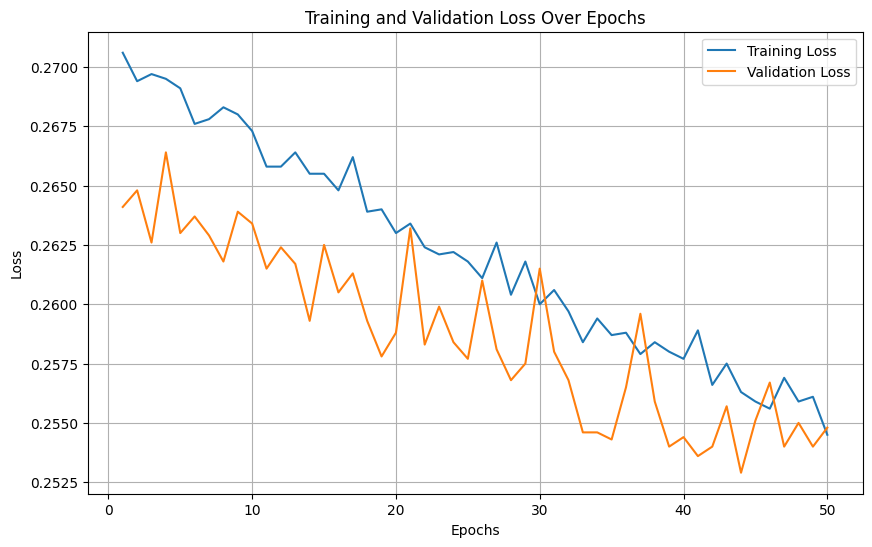

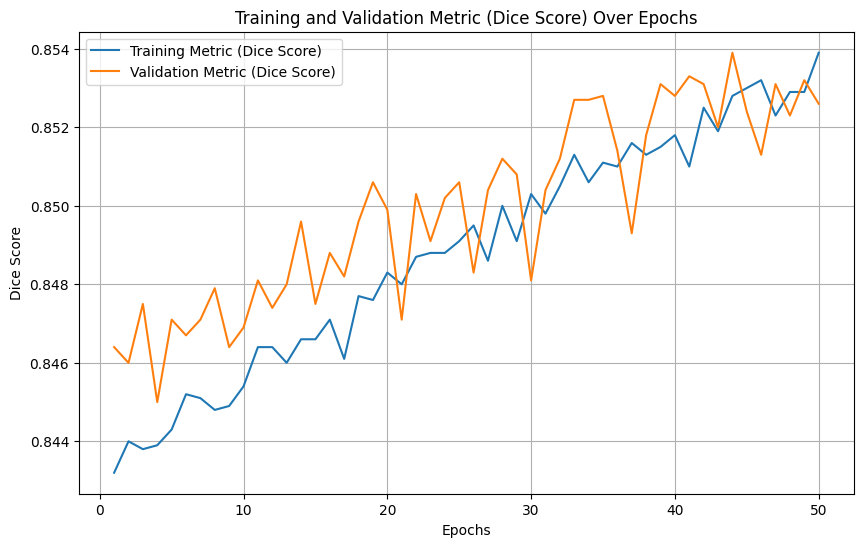

In [ ]:
plot_loss_metric(training_loss,validation_loss,training_metric,validation_metric)

# EXTRA different loss/metric


## MODEL2:

* Architecture: UNET
* Backbone: resnext50 32x4d
* pretrained: imagenet
* Loss: BCE
* Metric: DICE coef
* Epochs: 30
* Batch size: 32
* Early stopping with patience: 10

In [ ]:
archi = 'unet'
backbone = 'resnext50_32x4d'
model_name=archi+'_'+backbone

In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi,backbone=backbone).to(device)
bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

In [ ]:
# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [ ]:
# Training parameters
num_epochs = 50 # I run this model by mistake for 30 epochs but I interrupted the process
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

In [ ]:
# TensorBoard setup
# writer = SummaryWriter('/content/drive/MyDrive/tensorboard_logs')

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss, running_dice = 0.0, 0.0

    for batch_index, (images, masks) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [TRAIN]')):
        images, masks = images.to(device), masks.to(device)
        masks = masks.unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)

        with autocast():
            outputs = model(images)
            loss = bce_loss(outputs, masks)

        scaler.scale(loss / accumulation_steps).backward()
        if (batch_index + 1) % accumulation_steps == 0 or batch_index + 1 == len(train_dataloader):
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item()
        dice_score = dice_coefficient(outputs, masks)
        running_dice += dice_score

    scheduler.step(running_loss)

    avg_train_loss = running_loss / len(train_dataloader)
    avg_train_dice = running_dice / len(train_dataloader)
    # writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    # writer.add_scalar('Dice/Train', avg_train_dice, epoch)

    # Validation phase
    model.eval()
    val_loss, val_dice = 0.0, 0.0
    with torch.no_grad():
        for images, masks in tqdm(valid_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [VALIDATION]'):
            images, masks = images.to(device), masks.to(device)
            masks = masks.unsqueeze(1)
            outputs = model(images)
            loss = bce_loss(outputs, masks)
            val_loss += loss.item()
            dice_score = dice_coefficient(outputs, masks)
            val_dice += dice_score

    avg_val_loss = val_loss / len(valid_dataloader)
    avg_val_dice = val_dice / len(valid_dataloader)
    # writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    # writer.add_scalar('Dice/Validation', avg_val_dice, epoch)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Dice: {avg_train_dice:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}")

    # Save model every 2 epochs
    if (epoch + 1) % save_interval == 0:
        save_path = f'/content/drive/MyDrive/{model_name}_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), save_path)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f'/content/drive/MyDrive/{model_name}_best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            early_stop = True
            break

if not early_stop:
    print("Completed all epochs without early stopping.")

# Save the final model
torch.save(model.state_dict(), f'/content/drive/MyDrive/{model_name}_final_model.pth')
# writer.close()

Epoch 1/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 1/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 1/50
Training Loss: 0.1892, Training Dice: 0.6734
Validation Loss: 0.1668, Validation Dice: 0.6528


Epoch 2/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 2/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 2/50
Training Loss: 0.1514, Training Dice: 0.7094
Validation Loss: 0.1204, Validation Dice: 0.7595


Epoch 3/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 3/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 3/50
Training Loss: 0.1280, Training Dice: 0.7608
Validation Loss: 0.1035, Validation Dice: 0.7944


Epoch 4/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 4/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 4/50
Training Loss: 0.1207, Training Dice: 0.7764
Validation Loss: 0.1059, Validation Dice: 0.7850


Epoch 5/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 5/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 5/50
Training Loss: 0.1175, Training Dice: 0.7830
Validation Loss: 0.1083, Validation Dice: 0.7859


Epoch 6/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 6/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 6/50
Training Loss: 0.1133, Training Dice: 0.7906
Validation Loss: 0.1017, Validation Dice: 0.7949


Epoch 7/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 7/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 7/50
Training Loss: 0.1110, Training Dice: 0.7956
Validation Loss: 0.0969, Validation Dice: 0.8025


Epoch 8/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 8/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 8/50
Training Loss: 0.1103, Training Dice: 0.7972
Validation Loss: 0.0955, Validation Dice: 0.8040


Epoch 9/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 9/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 9/50
Training Loss: 0.1083, Training Dice: 0.8006
Validation Loss: 0.1126, Validation Dice: 0.7866


Epoch 10/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 10/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 10/50
Training Loss: 0.1083, Training Dice: 0.8007
Validation Loss: 0.0923, Validation Dice: 0.8182


Epoch 11/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 11/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 11/50
Training Loss: 0.1049, Training Dice: 0.8070
Validation Loss: 0.0951, Validation Dice: 0.8069


Epoch 12/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 12/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 12/50
Training Loss: 0.1044, Training Dice: 0.8073
Validation Loss: 0.0939, Validation Dice: 0.8198


Epoch 13/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 13/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 13/50
Training Loss: 0.1030, Training Dice: 0.8102
Validation Loss: 0.0904, Validation Dice: 0.8247


Epoch 14/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 14/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 14/50
Training Loss: 0.1012, Training Dice: 0.8142
Validation Loss: 0.0960, Validation Dice: 0.8168


Epoch 15/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 15/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 15/50
Training Loss: 0.1004, Training Dice: 0.8161
Validation Loss: 0.0898, Validation Dice: 0.8241


Epoch 16/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 16/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 16/50
Training Loss: 0.1016, Training Dice: 0.8137
Validation Loss: 0.0874, Validation Dice: 0.8248


Epoch 17/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 17/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 17/50
Training Loss: 0.0986, Training Dice: 0.8195
Validation Loss: 0.0898, Validation Dice: 0.8296


Epoch 18/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 18/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 18/50
Training Loss: 0.0985, Training Dice: 0.8192
Validation Loss: 0.0882, Validation Dice: 0.8252


Epoch 19/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 19/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 19/50
Training Loss: 0.0983, Training Dice: 0.8197
Validation Loss: 0.0861, Validation Dice: 0.8293


Epoch 20/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 20/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 20/50
Training Loss: 0.0966, Training Dice: 0.8230
Validation Loss: 0.0862, Validation Dice: 0.8255


Epoch 21/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 21/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 21/50
Training Loss: 0.0969, Training Dice: 0.8212
Validation Loss: 0.0883, Validation Dice: 0.8262


Epoch 22/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 22/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 22/50
Training Loss: 0.0973, Training Dice: 0.8214
Validation Loss: 0.0845, Validation Dice: 0.8336


Epoch 23/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 23/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 23/50
Training Loss: 0.0956, Training Dice: 0.8245
Validation Loss: 0.0860, Validation Dice: 0.8300


Epoch 24/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 24/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 24/50
Training Loss: 0.0985, Training Dice: 0.8195
Validation Loss: 0.0847, Validation Dice: 0.8307


Epoch 25/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 25/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 25/50
Training Loss: 0.0967, Training Dice: 0.8235
Validation Loss: 0.0860, Validation Dice: 0.8359


Epoch 26/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 26/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 26/50
Training Loss: 0.0933, Training Dice: 0.8286
Validation Loss: 0.0896, Validation Dice: 0.8297


Epoch 27/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 27/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 27/50
Training Loss: 0.0985, Training Dice: 0.8196
Validation Loss: 0.0828, Validation Dice: 0.8374


Epoch 28/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 28/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 28/50
Training Loss: 0.0911, Training Dice: 0.8321
Validation Loss: 0.0817, Validation Dice: 0.8327


Epoch 29/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 29/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 29/50
Training Loss: 0.0912, Training Dice: 0.8328
Validation Loss: 0.0819, Validation Dice: 0.8430


Epoch 30/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

Epoch 30/50 [VALIDATION]:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch 30/50
Training Loss: 0.0921, Training Dice: 0.8311
Validation Loss: 0.0819, Validation Dice: 0.8374


Epoch 31/50 [TRAIN]:   0%|          | 0/1378 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## MODEL3:

* Architecture: UNET
* Backbone: resnet50
* pretrained: imagenet
* Loss: BCEloss+DICEloss
* Metric: IoU score
* Epochs: 30
* Batch size: 32
* Early stopping with patience: 10

In [ ]:
def calculate_iou(preds, masks):
    preds = preds.float() > 0.5  # You may not need the float() conversion if preds are already float
    tp, fp, fn, tn = smp.metrics.get_stats(preds, masks, mode='binary')  # Use mode='binary' for binary segmentation
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    return iou_score

In [ ]:
archi = 'unet'
backbone = 'resnet50'
model_name = archi + '_' + backbone

In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(architecture=archi, backbone=backbone).to(device)
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
scaler = GradScaler()

In [ ]:
# DataLoaders
n_cpu = 8
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

In [ ]:
# Training parameters
num_epochs = 30
best_val_loss = float('inf')
patience, epochs_no_improve, early_stop = 10, 0, False
save_interval = 2  # Save weights every 2 epochs
accumulation_steps = 4  # Gradient accumulation steps

I improved the run process andI just tried different Loss and Metrics to see how the model performs

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss, running_dice, running_iou = 0.0, 0.0, 0.0
        dataloader = train_dataloader if phase == 'train' else valid_dataloader

        for images, masks in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
            images, masks = images.to(device), masks.to(device)
            masks = masks.unsqueeze(1).float()

            optimizer.zero_grad(set_to_none=True)

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                with autocast():
                    outputs = model(images)
                    bce = bce_loss(outputs, masks)
                    dice = dice_loss(outputs, masks)
                    loss = bce + dice

                # Backward pass and optimize
                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)

            # Loss
            running_loss += loss.item() * images.size(0)
            # Dices loss
            running_dice += dice.item() * images.size(0)

            # IoU score
            preds = torch.sigmoid(outputs) > 0.5
            masks_int = masks > 0.5  # Convert masks to long for smp.metrics.get_stats
            tp, fp, fn, tn = smp.metrics.get_stats(preds.long(), masks_int.long(), mode='binary')
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            running_iou += iou.item() * images.size(0)

        # Epoch-level statistics
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_dice = running_dice / len(dataloader.dataset)
        epoch_iou = running_iou / len(dataloader.dataset)
        print(f"{phase.capitalize()} Total Loss: {epoch_loss:.4f} Specific Dice Loss: {epoch_dice:.4f} IoU: {epoch_iou:.4f}")

        # Checkpointing and early stopping
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'{model_name}_best.pth')
            else:
                epochs_no_improve += 1
            scheduler.step(epoch_loss)

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        early_stop = True
        break

# Load best model weights
if early_stop:
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'{model_name}_final.pth')

Epoch 1/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.4907 Specific Dice Loss: 0.3148 IoU: 0.5789


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3763 Specific Dice Loss: 0.2390 IoU: 0.6547
Epoch 2/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3930 Specific Dice Loss: 0.2499 IoU: 0.6417


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3557 Specific Dice Loss: 0.2294 IoU: 0.6654
Epoch 3/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3652 Specific Dice Loss: 0.2320 IoU: 0.6629


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3668 Specific Dice Loss: 0.2351 IoU: 0.6575
Epoch 4/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3507 Specific Dice Loss: 0.2225 IoU: 0.6745


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3231 Specific Dice Loss: 0.2115 IoU: 0.6926
Epoch 5/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3411 Specific Dice Loss: 0.2165 IoU: 0.6816


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3325 Specific Dice Loss: 0.2148 IoU: 0.6831
Epoch 6/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3286 Specific Dice Loss: 0.2086 IoU: 0.6914


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3026 Specific Dice Loss: 0.1933 IoU: 0.7097
Epoch 7/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3198 Specific Dice Loss: 0.2031 IoU: 0.6982


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3062 Specific Dice Loss: 0.1951 IoU: 0.7089
Epoch 8/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3145 Specific Dice Loss: 0.1994 IoU: 0.7029


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2937 Specific Dice Loss: 0.1911 IoU: 0.7154
Epoch 9/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3098 Specific Dice Loss: 0.1968 IoU: 0.7063


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2985 Specific Dice Loss: 0.2001 IoU: 0.7161
Epoch 10/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3055 Specific Dice Loss: 0.1937 IoU: 0.7104


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2917 Specific Dice Loss: 0.1910 IoU: 0.7191
Epoch 11/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.3006 Specific Dice Loss: 0.1908 IoU: 0.7139


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2942 Specific Dice Loss: 0.1939 IoU: 0.7161
Epoch 12/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2985 Specific Dice Loss: 0.1892 IoU: 0.7159


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.3037 Specific Dice Loss: 0.2013 IoU: 0.7083
Epoch 13/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2907 Specific Dice Loss: 0.1844 IoU: 0.7222


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2708 Specific Dice Loss: 0.1760 IoU: 0.7355
Epoch 14/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2905 Specific Dice Loss: 0.1842 IoU: 0.7225


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2653 Specific Dice Loss: 0.1748 IoU: 0.7401
Epoch 15/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2879 Specific Dice Loss: 0.1826 IoU: 0.7246


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2753 Specific Dice Loss: 0.1766 IoU: 0.7310
Epoch 16/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2854 Specific Dice Loss: 0.1810 IoU: 0.7266


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2635 Specific Dice Loss: 0.1734 IoU: 0.7408
Epoch 17/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2845 Specific Dice Loss: 0.1806 IoU: 0.7271


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2633 Specific Dice Loss: 0.1733 IoU: 0.7424
Epoch 18/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2789 Specific Dice Loss: 0.1770 IoU: 0.7319


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2597 Specific Dice Loss: 0.1665 IoU: 0.7445
Epoch 19/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2762 Specific Dice Loss: 0.1753 IoU: 0.7340


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2633 Specific Dice Loss: 0.1712 IoU: 0.7414
Epoch 20/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2765 Specific Dice Loss: 0.1754 IoU: 0.7338


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2661 Specific Dice Loss: 0.1701 IoU: 0.7390
Epoch 21/30


Train Phase:   0%|          | 0/1378 [00:00<?, ?it/s]

Train Total Loss: 0.2733 Specific Dice Loss: 0.1733 IoU: 0.7367


Val Phase:   0%|          | 0/173 [00:00<?, ?it/s]

Val Total Loss: 0.2604 Specific Dice Loss: 0.1698 IoU: 0.7443
Early stopping at epoch 21
